# Julia Notebook for _Gauges and Accelerated Optimization over Smooth and/or Strongly Convex Sets_
### Ning Liu, Benjamin Grimmer

This notebook follows along the idea presented in _Gauges and Accelerated Optimization over Smooth and/or Strongly Convex Sets_. We present implementations of algorithms in Section 4, and apply them to feasibility problems and constrained optimization.   

## $p$-norm Ellipsoid Feasibility Problems

We implement subgradient methods, generalized gradient methods, accelerated generalized gradient methods and level methods given smooth or strongly convex structure.
The following table is the tuned parameters $\eta$\, note for accelerated method we have two parameters $L$ and $\mu$.

| Algorithm\(p1,p2) | (1.5, 1.8) | (2,2) | (3,4) |
| --- | --- | --- | --- |
| Subgrad Const  |  .46 | .037 | .027 |
| Subgrad 1/Sqrt(k)  |  .37 | .35 | .094 |
| GenGrad Accel  | 14, .39 | 12, .13 | 25, .35 |

In [2]:
using Roots
using LinearAlgebra
using ForwardDiff
using Distributions
using Random
using PyPlot
using CSV
using DataFrames

In [3]:
# Gauge 
function gauge(f, x)
    lambda=1.0
    if norm(x)<=0.00000001
    gamma = 0
    else
        if f(x/lambda)-1>0
            while f(x/lambda)-1>0
                lambda = 2 * lambda
            end
            if f(x/lambda)-1==0
                gamma = lambda
            else
                g = c -> f(x/c)-1
                gamma = find_zero(g, (lambda/2,lambda), Bisection())
            end
        elseif f(x/lambda)-1 < 0
            while f(x/lambda)-1<0
                lambda = 0.5 * lambda
            end
            if f(x/lambda)-1==0
                gamma = lambda
            else 
                g = c -> f(x/c)-1
                gamma = find_zero(g, (lambda,2*lambda), Bisection())
            end
        else 
            gamma = lambda
        end
    end
    return gamma
end

# Half gauge squared 
function half_gauge_squared(f,x)
    return 0.5*gauge(f,x)^2
end

# Subgradient of gauge 
function subgrad_gauge(f,gradf,x)
    if norm(x)<=0.00000001
        return zeros(length(x))
    else
        y = x/gauge(f,x)
        n = gradf(y)
        return n/dot(n,y)
    end
end

# Subgradient of half gauge squared
function subgrad_half_gauge_squared(f,gradf,x)
    if norm(x)<=0.00000001
        return zeros(dim(x))
    else
        val=gauge(f,x)
        y = x/val
        n = gradf(y)
        return val*n/dot(n,y)
    end
end

# Translated gauge
function gauge(f, x, e)
    trans_f = y -> f(y+e)
    return gauge(trans_f, x-e)
end

# Translated half gauge squared
function half_gauge_squared(f,x,e)
    trans_f = y->f(y+e)
    return half_gauge_squared(trans_f, x-e)
end

# Translated subgradient of gauge
function subgrad_gauge(f, gradf, x, e)
    trans_f = y -> f(y+e)
    trans_gradf = y -> gradf(y+e)
    return subgrad_gauge(trans_f, trans_gradf, x-e)
end

# Translated subgradient of half gauge squared
function subgrad_half_gauge_squared(f, gradf, x, e)
    trans_f = y -> f(y+e)
    trans_gradf = y -> gradf(y+e)
    return subgrad_half_gauge_squared(trans_f, trans_gradf, x-e)
end





local_half_gauge_squared_smooth (generic function with 1 method)

In [5]:
function subgrad_const(f1, f2, gradf1, gradf2, xk, eta, max_iter = 10000)
    
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        f1k = f1(xk)
        f2k = f2(xk)
        
        if f1k >= f2k
            ret[num_iter] = f1k
            grad = gradf1(xk)
        else
            ret[num_iter] = f2k
            grad = gradf2(xk)
        end

        xk = xk-eta*grad
        num_iter +=1
    end
    return ret, num_iter-1
end

function subgrad_sqrt(f1, f2, gradf1, gradf2, xk, eta, max_iter = 10000)
    
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        f1k = f1(xk)
        f2k = f2(xk)
        
        if f1k >= f2k
            ret[num_iter] = f1k
            grad = gradf1(xk)
        else
            ret[num_iter] = f2k
            grad = gradf2(xk)
        end

        xk = xk-eta/sqrt(num_iter+10)*grad
        
        num_iter +=1
    end
    return ret, num_iter-1
end

function subgrad_linear(f1, f2, gradf1, gradf2, xk, eta, max_iter = 10000)
    
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        f1k = f1(xk)
        f2k = f2(xk)
        
        if f1k >= f2k
            ret[num_iter] = f1k
            grad = gradf1(xk)
        else
            ret[num_iter] = f2k
            grad = gradf2(xk)
        end

        xk = xk-eta/(num_iter+10)*grad
        num_iter +=1
    end
    return ret, num_iter-1
end

function dx_min_max(f1, f2, gradf1, gradf2, xk, alpha)

    a1 = gradf1(xk)
    a2 = gradf2(xk)
    b1 = f1(xk)
    b2 = f2(xk)
    b = max(b1, b2)
    
    dx1 = -1 * a1 * alpha
    dx2 = -1 * a2 * alpha

    if b1+dot(a1,dx1) > b2+dot(a2,dx1)
        dx = dx1
    elseif b1+dot(a1,dx2) < b2+dot(a2,dx2)
        dx = dx2
    else
        theta = (1/alpha * (b2-b1)+dot(a1-a2,a1))/norm(a1-a2,2)^2
        dx = -1 * ((1-theta) * a1 + theta * a2) * alpha
    end
    return dx, b
end

function GenGrad_const(f1, f2, gradf1, gradf2, x0, eta, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter <= max_iter
        dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, eta)

        xk = xk + dx
        num_iter +=1
        
    end
    return ret, num_iter-1
end

function GenGrad_sqrt(f1, f2, gradf1, gradf2, x0, eta, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    
    while num_iter<=max_iter
    alpha = eta/sqrt(num_iter+10)
    dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, alpha)
        
    xk = xk+ dx
    num_iter += 1
    end
    return ret, num_iter-1
end



function GenGradient_linear(f1, f2, gradf1, gradf2, x0, eta, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    
    while num_iter<=max_iter
        alpha = eta/(num_iter+10)
        dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, alpha)
        
        xk = xk+ dx
        num_iter += 1
    end
    return ret, num_iter-1
end



function level_method(f1, f2, gradf1, gradf2, x0, m, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter<=max_iter
        
        a1 = gradf1(xk)
        a2 = gradf2(xk)
        b1 = f1(xk)
        b2 = f2(xk)
        b = max(b1, b2)

        dx1 = -(b1-m)/norm(a1,2)^2*a1
        dx2 = -(b2-m)/norm(a2,2)^2*a2

        if b1 + dot(a1,dx1) > b2 + dot(a2,dx1)
            dx = dx1
        elseif b1 + dot(a1,dx2) < b2 + dot(a2,dx2)
            dx = dx2
        else
            lambda = inv([norm(a1,2)^2 dot(a1,a2); dot(a1,a2) norm(a2,2)^2])*[m-b1; m-b2]
            dx = lambda[1]*a1+lambda[2]*a2
        end
        
        ret[num_iter] = b
        xk = xk + dx
        num_iter +=1
    end
    return ret, num_iter-1
end



function GenGrad_accel(f1, f2, gradf1, gradf2, x0, L, mu, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    q = mu/L
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    while num_iter <= max_iter
        dx, ret[num_iter] = dx_min_max(f1, f2, gradf1, gradf2, xk, 1/L)

            
        y_curr = xk + dx 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr
        
        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        num_iter +=1
    end
    return ret, num_iter-1
end

function conjugate_gradient(A, b, x0, max_iter)
    xk = x0
    rk = b-A*xk
    pk = rk
    
    num_iter = 1

    while num_iter <= max_iter
        apk = A*pk
        rks = dot(rk, rk)
        if rks<0.0000001
            break 
        end
        alpha = rks/dot(pk, apk)
        
        xk = xk + alpha*pk
        rk = rk - alpha*apk
        beta = dot(rk, rk)/rks
        pk = rk + beta*pk

        num_iter+=1
    end
    return xk
end


function cleanData(data)
    for i in 2:length(data)
        data[i] = min(data[i-1], data[i])
    end
    return data
end

cleanData (generic function with 1 method)

### Strongly Convex Setting(1<p<2)

In [4]:
# Generating random test data
p3 = 1.5
p4 = 1.8

m = 1600
n = 1600

Random.seed!(21)
x0 = zeros(n)

x_true = randn(n)
A3 = randn(m,n)
A4 = randn(m,n)
d3 = PGeneralizedGaussian(0,1/sqrt(2),p3)
d4 = PGeneralizedGaussian(0,1/sqrt(2),p4)
epsilon3 = rand(d3,m)
epsilon4 = rand(d4,m)

# Generating data samples to get b 
N = 10000
i = 1
norm3 = zeros(N)
norm4 = zeros(N)
while i <= N
    norm3[i] = norm(epsilon3, p3)
    norm4[i] = norm(epsilon4, p4)
    i+=1
end
tau3 = quantile(norm3, 0.975)
tau4 = quantile(norm4, 0.975)
A3 = A3/tau3
A4 = A4/tau4
b3 = A3*x_true + epsilon3/tau3
b4 = A4*x_true + epsilon4/tau4

# Computing a point e in the constraint set
e3 = conjugate_gradient(A3'*A3, A3'*b3, x0, 35)
e4 = conjugate_gradient(A4'*A4, A4'*b4, x0, 35)

println("tau3=", tau3)
println("tau4=", tau4)

# Define objective function f and subgradient g
h3 = x -> norm(A3*x-b3,p3)^p3
h4 = x -> norm(A4*x-b4,p4)^p4
f3 = x -> half_gauge_squared(h3,x,e3)
f4 = x -> half_gauge_squared(h4,x,e4)
gh3 = x -> ForwardDiff.gradient(h3, x)
gh4 = x -> ForwardDiff.gradient(h4, x)
gf3 = x -> subgrad_half_gauge_squared(h3,gh3,x,e3)
gf4 = x -> subgrad_half_gauge_squared(h4,gh4,x,e4)


tau3=73.28675412608531
tau4=30.040565517574755


#31 (generic function with 1 method)

In [5]:
# Getting the optimal objective value
sc_long, iter_long= GenGrad_sqrt(f3,f4,gf3,gf4,x0,0.67,2000)
sc_long = cleanData(sc_long)
# 0.25655876561811836

2000-element Vector{Float64}:
 4171.510049460668
 1972.3317474264713
 1952.3065721531875
 1952.3065721531875
 1952.3065721531875
 1952.3065721531875
 1909.7587594285615
  538.6852930056097
  147.71811954379456
   65.05482215497018
   28.507142745032517
   17.656094192837706
   11.249932236368815
    ⋮
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483
    0.2563382897324483

In [6]:
sc1, iter21= subgrad_const(f3,f4,gf3,gf4,x0,0.046,200)
sc2, iter22= subgrad_sqrt(f3,f4,gf3,gf4,x0,0.37,200)
sc7, iter27= GenGrad_accel(f3,f4,gf3,gf4,x0,14.0,0.39,200)
sc8, iter28= level_method(f3,f4,gf3,gf4,x0,sc_long[2000],200)
sc9, iter29= level_method(f3,f4,gf3,gf4,x0,1,200)


([4171.510049460668, 1294.3806785072134, 433.4358898220767, 149.86105110011798, 74.45363309295533, 44.47864574781439, 32.954467464854645, 20.315214776528492, 17.45461550979234, 9.528507624969112  …  0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002], 200)

In [7]:
sc1 = cleanData(sc1)
sc2 = cleanData(sc2)
sc7 = cleanData(sc7)
sc8 = cleanData(sc8)
sc9 = cleanData(sc9)

200-element Vector{Float64}:
 4171.510049460668
 1294.3806785072134
  433.4358898220767
  149.86105110011798
   74.45363309295533
   44.47864574781439
   32.954467464854645
   20.315214776528492
   17.45461550979234
    9.528507624969112
    6.54260601193732
    3.599418042814089
    2.3819479000873236
    ⋮
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992
    0.9999999999999992

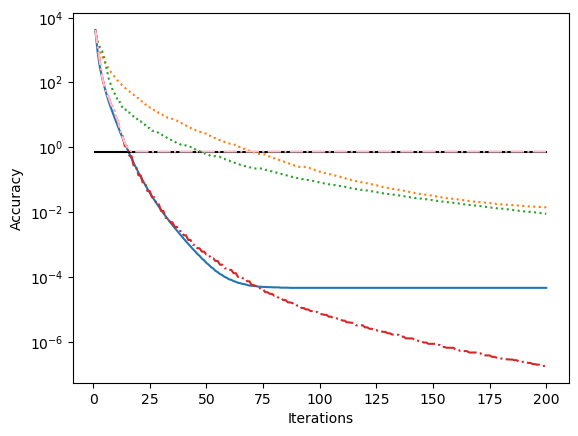

In [26]:
PyPlot.semilogy(1:iter27, sc7.-sc_long[2000], label = "Rad_Accel", linestyle = "solid")
PyPlot.semilogy(1:iter21, ones(200)*(1-sc_long[2000]), color="black", linestyle = "solid")
PyPlot.semilogy(1:iter21, sc1.-sc_long[2000], label = "Rad_Subgrad", linestyle = "dotted")
PyPlot.semilogy(1:iter22, sc2.-sc_long[2000], label = "Rad_Subgrad_1/sqrt(k)", linestyle = "dotted")
PyPlot.semilogy(1:iter28, sc8.-sc_long[2000], label = "Level_Method_Opt", linestyle = "dashdot")
PyPlot.semilogy(1:iter29, sc9.-sc_long[2000], label = "Level_Method_1", color = "pink", linestyle = "dashdot")
# legend()


# ylim(1e-8,1e4)
xlabel("Iterations")
ylabel("Accuracy")

# savefig("strongly_convex_1600_new")

### Smooth and Strongly convex setting (p=2)

In [14]:
# Generating random test data
p5 = 2
p6 = 2

m = 1600
n = 1600

Random.seed!(21)

x0 = zeros(n)

x_true = randn(n)
A5 = randn(m,n)
A6 = randn(m,n)
d5 = PGeneralizedGaussian(0,1/sqrt(2),p5)
d6 = PGeneralizedGaussian(0,1/sqrt(2),p6)
epsilon5 = rand(d5,m)
epsilon6 = rand(d6,m)

# Generating data samples to get b
N = 10000
i = 1
norm5 = zeros(N)
norm6 = zeros(N)
while i <= N
    norm5[i] = norm(epsilon5, p5)
    norm6[i] = norm(epsilon6, p6)
    i+=1
end
tau5 = quantile(norm5, 0.975)
tau6 = quantile(norm6, 0.975)
A5 = A5/tau5
A6 = A6/tau6
b5 = A5*x_true + epsilon5/tau5
b6 = A6*x_true + epsilon6/tau6

# Computing a point e in the constraint set
e5 = conjugate_gradient(A5'*A5, A5'*b5, x0, 35)
e6 = conjugate_gradient(A6'*A6, A6'*b6, x0, 35)

println("tau5=", tau5)
println("tau6=", tau6)

# Define objective function f and subgradient g
h5 = x -> norm(A5*x-b5,p5)^p5
h6 = x -> norm(A6*x-b6,p6)^p6
f5 = x -> half_gauge_squared(h5,x,e5)
f6 = x -> half_gauge_squared(h6,x,e6)
gh5 = x -> 2*A5'*(A5*x-b5)
gh6 = x -> 2*A6'*(A6*x-b6)
gf5 = x -> subgrad_half_gauge_squared(h5,gh5,x,e5)
gf6 = x -> subgrad_half_gauge_squared(h6,gh6,x,e6)



tau5=19.79154194373338
tau6=19.626183369780414


#63 (generic function with 1 method)

In [15]:
# Getting the optimal objective value
g_long3, iter_long3 = GenGrad_accel(f5,f6,gf5,gf6,x0,12,0.13,2000)
g_long3 = cleanData(g_long3)

2000-element Vector{Float64}:
 4707.188685902336
 1271.5864830950404
  393.20467155433704
  184.55292170567765
  100.45252603697206
   53.147623021789116
   30.83419084315236
   15.051448453493038
    6.717536813954314
    3.355591531825772
    1.8120673733293269
    1.1808204241403875
    0.8828046312558583
    ⋮
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239
    0.2474462044628239

In [16]:
g1, iter31 = subgrad_const(f5,f6,gf5,gf6,x0,0.037,200)
g2, iter32 = subgrad_sqrt(f5,f6,gf5,gf6,x0,0.35,200)
g7, iter37 = GenGrad_accel(f5,f6,gf5,gf6,x0,12,0.13,200)
g8, iter38 = level_method(f5,f6,gf5,gf6,x0,g_long3[2000],200)
g9, iter39 = level_method(f5,f6,gf5,gf6,x0,1,200)

([4707.188685902336, 1446.6627915470035, 482.47144632165674, 162.31542277824124, 70.3661323305508, 45.53510244819273, 32.07004687270493, 22.37076859866827, 16.577223046741462, 11.88866035224327  …  1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998], 200)

In [17]:
g1 = cleanData(g1)
g2 = cleanData(g2)
g7 = cleanData(g7)
g8 = cleanData(g8)
g9 = cleanData(g9)

200-element Vector{Float64}:
 4707.188685902336
 1446.6627915470035
  482.47144632165674
  162.31542277824124
   70.3661323305508
   45.53510244819273
   32.07004687270493
   22.37076859866827
   16.577223046741462
   11.88866035224327
    9.235513452478184
    6.600571149402609
    5.4711020203225615
    ⋮
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979
    0.9999999999999979

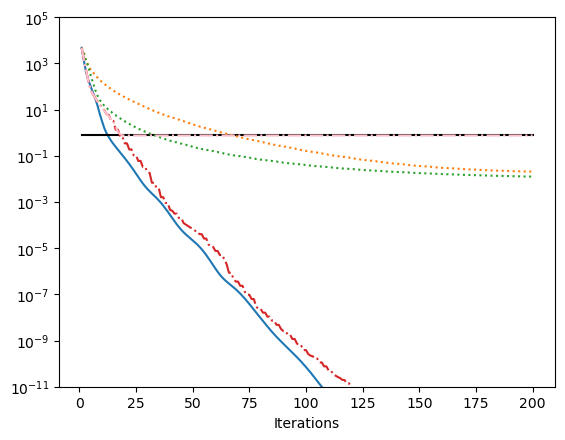

In [25]:
PyPlot.semilogy(1:iter37, g7.-g_long3[2000], label = "Rad_Accel", linestyle = "solid")
PyPlot.semilogy(1:iter31, ones(200)*(1-g_long3[2000]), color="black", linestyle = "solid")
PyPlot.semilogy(1:iter31, g1.-g_long3[2000], label = "Rad_Subgrad_Const", linestyle = "dotted")
PyPlot.semilogy(1:iter32, g2.-g_long3[2000], label = "Rad_Subgrad_1/sqrt(k)", linestyle = "dotted")
PyPlot.semilogy(1:iter38, g8.-g_long3[2000], label = "Level_Method_Opt", linestyle = "dashdot")
PyPlot.semilogy(1:iter39, g9.-g_long3[2000], label = "Level_Method_1", color = "pink", linestyle = "dashdot")
# legend()

ylim(1e-11,1e5)
xlabel("Iterations")
# ylabel("Accuracy")

# savefig("smooth_sconvex_1600_new")

### Smooth Setting(p>2)

In [19]:
# Generating random test data
p1 = 3
p2 = 4

m = 1600
n = 1600
Random.seed!(21)

x0 = zeros(n)

x_true = randn(n)
A1 = randn(m,n)
A2 = randn(m,n)
d1 = PGeneralizedGaussian(0,1/sqrt(2),p1)
d2 = PGeneralizedGaussian(0,1/sqrt(2),p2)
epsilon1 = rand(d1,m)
epsilon2 = rand(d2,m)

# Generating data samples to get b
N = 10000
i = 1
norm1 = zeros(N)
norm2 = zeros(N)
while i <= N
    norm1[i] = norm(epsilon1, p1)
    norm2[i] = norm(epsilon2, p2)
    i+=1
end
tau1 = quantile(norm1, 0.975)
tau2 = quantile(norm2, 0.975)
A1 = A1/tau1
A2 = A2/tau2
b1 = A1*x_true + epsilon1/tau1
b2 = A2*x_true + epsilon2/tau2

# Computing a point e in the constraint set
e1 = conjugate_gradient(A1'*A1, A1'*b1, x0, 35)
e2 = conjugate_gradient(A2'*A2, A2'*b2, x0, 35)


println("tau1=", tau1)
println("tau2=", tau2)

# Define objective function f and subgradient g
h1 = x -> norm(A1*x-b1,p1)^p1
h2 = x -> norm(A2*x-b2,p2)^p2
f1 = x -> half_gauge_squared(h1,x,e1)
f2 = x -> half_gauge_squared(h2,x,e2)
gh1 = x -> ForwardDiff.gradient(h1, x)
gh2 = x -> ForwardDiff.gradient(h2, x)
gf1 = x -> subgrad_half_gauge_squared(h1,gh1,x,e1)
gf2 = x -> subgrad_half_gauge_squared(h2,gh2,x,e2)



tau1=5.679578362487603
tau2=3.1199488054778164


#79 (generic function with 1 method)

In [20]:
# Getting the optimal objective value
sm_long, iter_long= GenGrad_accel(f1,f2,gf1,gf2,x0,25,0.35,2000)
sm_long = cleanData(sm_long)

2000-element Vector{Float64}:
 11786.312581503702
  4111.909067581601
  1819.960786612656
   779.3291304992637
   376.53274087942793
   182.1710036711894
    97.1969020126522
    53.13656274155921
    30.829509204757088
    16.983147233530303
     9.961365754937669
     6.08944615637582
     3.6054375927638453
     ⋮
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082
     0.2503995369241082

In [21]:
sm1, iter1= subgrad_const(f1,f2,gf1,gf2,x0,0.027,200)
sm2, iter2= subgrad_sqrt(f1,f2,gf1,gf2,x0,0.094,200)
sm7, iter7= GenGrad_accel(f1,f2,gf1,gf2,x0,25,0.35,200)
sm8, iter8= level_method(f1,f2,gf1,gf2,x0,sm_long[2000],200)
sm9, iter9= level_method(f1,f2,gf1,gf2,x0,1,200)


([11786.312581503702, 4210.675248338268, 1535.6250198192524, 630.0371997302846, 428.3560868028946, 258.5918040552686, 211.15595906154337, 123.09047481108092, 121.95097378200099, 57.74371090350839  …  0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 1.0000000000000002], 200)

In [22]:
sm1 = cleanData(sm1)
sm2 = cleanData(sm2)
sm7 = cleanData(sm7)
sm8 = cleanData(sm8)
sm9 = cleanData(sm9)

200-element Vector{Float64}:
 11786.312581503702
  4210.675248338268
  1535.6250198192524
   630.0371997302846
   428.3560868028946
   258.5918040552686
   211.15595906154337
   123.09047481108092
   121.95097378200099
    57.74371090350839
    53.74749082477034
    25.363644388876967
    25.363644388876967
     ⋮
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948
     0.9999999999999948

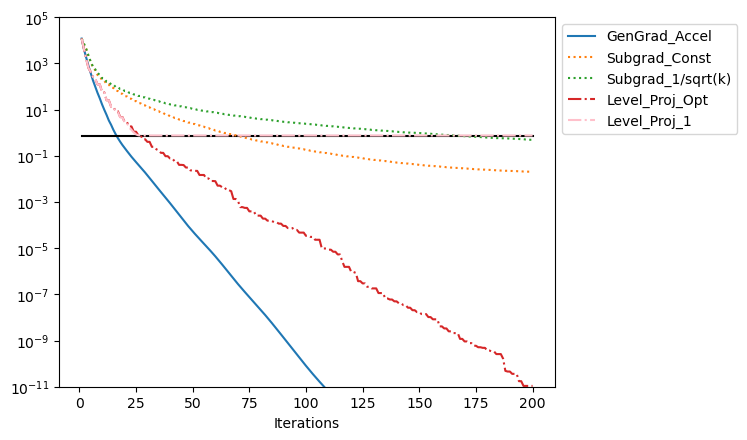

In [24]:
PyPlot.semilogy(1:iter7, sm7.-sm_long[2000], label = "GenGrad_Accel", linestyle = "solid")
PyPlot.semilogy(1:iter1, ones(200)*(1-sm_long[2000]), color="black", linestyle = "solid")
PyPlot.semilogy(1:iter1, sm1.-sm_long[2000], label = "Subgrad_Const", linestyle = "dotted")
PyPlot.semilogy(1:iter2, sm2.-sm_long[2000], label = "Subgrad_1/sqrt(k)", linestyle = "dotted")
PyPlot.semilogy(1:iter8, sm8.-sm7[200], label = "Level_Proj_Opt", linestyle = "dashdot")
PyPlot.semilogy(1:iter9, sm9.-sm_long[2000], label = "Level_Proj_1", color = "pink", linestyle = "dashdot")
# legend()

legend(bbox_to_anchor=(1.0,1.0))

ylim(1e-11,1e5)
xlabel("Iterations")
# ylabel("Accuracy")

# savefig("smooth_1600_new", bbox_inches="tight")

# Trust Region Optimization Problems

In [6]:
using Convex
using SCS
using LinearAlgebra
using Random
using Dates
using JuMP
using Mosek
using MosekTools
using COSMO
using Gurobi
using Interpolations
using Polynomials

In [7]:
function projected_accelerate(f, proj, x0, L, mu, max_iter=10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    q = mu/L
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    while num_iter <= max_iter
        obj, grad = f(xk)
        obj, notUsed = f(y_prev)
        ret[num_iter] = obj
        y_curr = proj(xk - 1/L*grad) 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr
        
        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        num_iter +=1
        
    end
    return ret, num_iter-1
end

function projected_accelerate(f, proj, x0, L, mu, seconds, samples)
    xk = x0
    ret = zeros(samples)
    i = 1
    q = mu/L
    
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    
    while ti <= tn
        obj, grad = f(xk)
        obj, notUsed = f(y_prev)
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = obj
        
        y_curr = proj(xk - 1/L*grad)
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr
        
        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        

        ti = round(Int64, time() * 1000)
        i +=1
        
    end
    return ret, i-1
end






function radial_accelerate(f1, f2, x0, L, mu, max_iter = 10000)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    q = mu/L
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    while num_iter <= max_iter
        b1, a1 = f1(xk)
        b2, a2 = f2(xk)
        b = max(b1, b2)
        ret[num_iter] = -1/sqrt(2*b)
        
        dx1 = -1 * a1/L
        dx2 = -1 * a2/L

        if b1 + dot(a1,dx1) > b2 + dot(a2,dx1)
            dx = dx1
        elseif b1 + dot(a1,dx2) < b2 + dot(a2,dx2)
            dx = dx2
        else
            theta = (L * (b2-b1)+dot(a1-a2,a1))/norm(a1-a2,2)^2
            dx = -1*((1-theta) * a1 + theta * a2)/L
        end

        y_curr = xk + dx 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr

        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        num_iter +=1
    end
    return -1*xk*ret[num_iter-1], ret, num_iter-1
end

function radial_accelerate(f1, f2, x0, L, mu, seconds, samples)
    xk = x0
    ret = zeros(samples)
    i = 1
    q = mu/L
    
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0 
    
    while ti <= tn
        b1, a1 = f1(xk)
        b2, a2 = f2(xk)
        b = max(b1, b2)
        

        
        dx1 = -1 * a1/L
        dx2 = -1 * a2/L

        if b1 + dot(a1,dx1) > b2 + dot(a2,dx1)
            dx = dx1
        elseif b1 + dot(a1,dx2) < b2 + dot(a2,dx2)
            dx = dx2
        else
            theta = (L * (b2-b1)+dot(a1-a2,a1))/norm(a1-a2,2)^2
            dx = -1*((1-theta) * a1 + theta * a2)/L
        end

        y_curr = xk + dx 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr

        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ret[timestep] = -1/sqrt(2*b)
        ti = round(Int64, time() * 1000)
        i +=1
    end
    return ret, i-1
end

function sw_subgrad(f,x0,eta,max_iter)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    
    while num_iter <= max_iter
        f1k,f2k,gradf1,gradf2=f(xk)
        if f2k <= 0
            alpha = eta1/sqrt(num_iter+10)
            ret[num_iter] = min(f1k,ret[num_iter])
            gradf = gradf1
        else
            alpha = eta2/sqrt(num_iter+10)
            gradf = gradf2
        end
        # alpha = eta/sqrt(num_iter+10)
        xk = xk - alpha*gradf
        num_iter += 1
    end
    return ret, num_iter
end

function sw_subgrad(f,x0,eta1,eta2,seconds,samples)
    xk = x0
    ret = zeros(samples)
    i = 1
    
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    
    while ti <= tn
        f1k,f2k,gradf1,gradf2=f(xk)
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        ti = round(Int64, time() * 1000)
        
        if f2k <= 0
            alpha = eta1/sqrt(i+10)
            ret[timestep] = min(f1k, ret[timestep])
            gradf = gradf1
        else
            alpha = eta2/sqrt(i+10)
            # print(f2k)
            gradf = gradf2
        end
        
        xk = xk - alpha*gradf
        i +=1
    end
    return ret, i
end

function agd(f,x0,L,mu,max_iter)
    xk = x0
    ret = zeros(max_iter)
    num_iter = 1
    q = mu/L
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    while num_iter <= max_iter
        f1k,f2k,gradf=f(xk)
        if f2k <= 0
            ret[num_iter] = min(f1k, ret[num_iter])
        end
        y_curr = xk - 1/L*gradf 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr

        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        num_iter +=1
    end
    return ret, num_iter
    
end

function agd(f,x0,L,mu,seconds,samples)
    xk = x0
    ret = zeros(samples)
    q = mu/L
    i = 1
    
    t0 = round(Int64, time() * 1000)
    ti = t0
    tn = t0 + 1000*seconds
    timestep=0
    
    alpha_prev = 0.5
    alpha_curr = (q - alpha_prev^2 + sqrt((q-alpha_prev^2)^2 + 4 * (alpha_prev)^2))/2
    beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
    y_prev = x0
    
    while ti <= tn
        f1k,f2k,gradf=f(xk)
        y_curr = xk - 1/L*gradf 
        xk = y_curr + beta*(y_curr-y_prev)
        y_prev = y_curr

        alpha_tem = alpha_curr
        alpha_curr = (q - alpha_curr^2 + sqrt((q-alpha_curr^2)^2 + 4 * (alpha_curr)^2))/2
        alpha_prev = alpha_tem
        
        beta = alpha_prev*(1 - alpha_prev)/(alpha_curr+alpha_prev^2)
        
        timestep = min(ceil(Int64, samples*(ti-t0)/(tn-t0))+1,samples)
        if f2k <= 0
            ret[timestep] = min(f1k, ret[timestep])
        end
        ti = round(Int64, time() * 1000)
        i +=1
    end
    return ret, i
    
end



function cleanData(data)
    for i in 2:length(data)
        data[i] = min(data[i-1], data[i])
    end
    return data
end

function cleanData2(data)
    for i in 2:length(data)
        data[i] = max(data[i-1], data[i])
    end
    return data
end

cleanData2 (generic function with 1 method)

### p = 2-norm Ellipsoid Constrained Optimization

We implement our radial methods on three different data dimensions (400,200), (800,400), (1600,800), comparing with solvers Gurobi, Mosek, COSMO, SOS.

The following table gives tuned parameters $L$ and $\mu$ of accelerated methods.

| Dimension (n,m) | (400, 200) | (800,400) | (1600,800) |
| --- | --- | --- | --- |
| Radial Accelerate  |  (110,1.2e-3) | (160, 8.1e-4) | (440,4.4e-4) |
| Switching Subgradient | (0.0025, 0.0077) | (0.021,0.0038) | (0.012,0.0018) |
| Ideal Lagragian Accelerate | (220000,24) | (990000,64) | (3800000,99) |

In [177]:
# Dimensions
n = 400
m = 200

# Generating random data test
x0 = zeros(n)
Random.seed!(123)
P = randn(n,n)
Q = P'*P
c = randn(n)

A = randn(m, n)
b = A*randn(n) + 1/m*randn(m)

# Computing a point e in the constraint set
e = conjugate_gradient(A'*A, A'*b, x0, 30)

# Translating original problem by e
b_e = b-A*e
c_e = c+Q*e

Ab_e = A'*b_e
nb = 1-norm(b_e,2)^2
AA = A'*A
function obj_grad(x)
    Px = P*x
    cx = dot(c_e,x)
    f_obj = 0.5*norm(Px,2)^2+cx-1
    gradf_obj = P'*(Px)+c_e
    return f_obj, gradf_obj
end

# Getting half upper radial squared function and its gradient of objective
function rad_obj_grad1(x)
    Px = P*x
    cx = dot(c_e,x)
    f_upradial = (cx+1+sqrt((cx+1)^2+2*norm(Px,2)^2))/2
    gradf_upradial = 0.5*c_e + 0.25/sqrt((cx+1)^2+2*norm(Px,2)^2)*(2*(cx+1)*c_e + 4*P'*(Px))
    return 0.5*f_upradial^2, f_upradial*gradf_upradial
end

# Getting half upper radial squared function and its gradient of constraint
function rad_obj_grad3(x)
    Ax = A*x
    Axb = dot(Ax,b_e)
    Ax_sq = norm(Ax,2)^2
    f_upradial = (-1*Axb+sqrt((Axb)^2+nb*Ax_sq))/nb
    gradf_upradial = 1/nb*(-1*Ab_e+(Axb*Ab_e+nb*A'*Ax)/(sqrt((Axb)^2+nb*Ax_sq)))
    if norm(x,2)<=1e-12
        return 0.5*f_upradial^2, zeros(n)
    else
        return 0.5*f_upradial^2, f_upradial*gradf_upradial
    end
end

function sw_obj_grad1(x)
    Px = P*x
    cx = dot(c_e,x)
    Ax = A*x
    f1 = 0.5*norm(Px,2)^2+cx-1
    gradf1 = P'*(Px)+c_e
    f2 = norm(Ax-b_e,2)^2-1
    gradf2 = 2*(A'*Ax-Ab_e)
    return f1, f2, gradf1, gradf2
end

function lagrange_obj_grad1(x)
    Px = P*x
    cx = dot(c_e,x)
    Ax = A*x
    
    f1 = 0.5*norm(Px,2)^2+cx-1
    f2 = norm(Ax-b_e,2)^2-1
    gradf = (Q+2*lambda*AA)*x+c_e-2*lambda*Ab_e
    return f1, f2, gradf
end


lagrange_obj_grad1 (generic function with 1 method)

In [178]:
opt_x,r1_long, stepr1_long = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 110, 0.0012, 100000)
r1_long = r1_long .+ 0.5*e'*Q*e.+dot(c,e)
r1_long = cleanData(r1_long)
# opt_x,r2_long, stepr2_long = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 160, 0.00081, 100000)
# r2_long = r2_long .+ 0.5*e'*Q*e.+dot(c,e)
# r2_long = cleanData(r2_long)
# opt_x,r3_long, stepr3_long = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 440, 0.00044, 100000)
# r3_long = r3_long .+ 0.5*e'*Q*e.+dot(c,e)
# r3_long = cleanData(r3_long)


100000-element Vector{Float64}:
 40073.40314281781
 40071.12251006287
 39928.54485017114
 39928.54485017114
 39928.54485017114
 39928.54485017114
 39928.54485017114
 39928.54485017114
 39890.20268404524
 39684.62947608839
 39500.73028561563
 39312.83497516758
 38880.67857696815
     ⋮
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063
 17758.732431673063

In [190]:
_,_, grad1, grad2=sw_obj_grad1(opt_x)
opt_lambda = norm(grad1,2)/norm(grad2,2)
lambda = opt_lambda


128.5485435400021

In [141]:
function extract_vectors(input_string::AbstractString, m, n)
    lines = split(strip(input_string), '\n')
    second_column = Float64[]
    last_column = Float64[]
    for line in lines
        columns = split(strip(line))
        push!(second_column, parse(Float64, columns[m]))
        push!(last_column, parse(Float64, columns[n]))
    end
    return (second_column, last_column)
end

extract_vectors (generic function with 1 method)

In [124]:
y1 = Variable(n)
Prob = minimize(0.5*quadform(y1,Q; assume_psd=true)+dot(c,y1)-1, norm(A*y1 - b, 2) <= 1)
# @time Convex.solve!(Prob, MOI.OptimizerWithAttributes(SCS.Optimizer, "eps_abs" => eps, "eps_rel" => eps, "eps_infeas" => eps); silent_solver=true)
# @time Convex.solve!(Prob, MOI.OptimizerWithAttributes(Mosek.Optimizer); silent_solver=true)
# @time Convex.solve!(Prob, MOI.OptimizerWithAttributes(COSMO.Optimizer))
@time Convex.solve!(Prob, Gurobi.Optimizer)
# z = evaluate(y1)
# Prob.optval

# model = Model(Gurobi.Optimizer)
# # set_optimizer_attribute(model, "Presolve", 0)

# JuMP.@variable(model, y[1:n])
# JuMP.@objective(model, Min, 0.5*y'*Q*y + c'*y - 1.0)
# JuMP.@constraint(model, [1; A*y-b] in SecondOrderCone())
# @time optimize!(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-19
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 801 rows, 2401 columns and 1280801 nonzeros
Model fingerprint: 0xc2a8a59d
Model has 1280800 quadratic objective terms
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [3e-07, 5e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-04, 4e+00]
  QObjective range [3e-05, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.73s
Presolved: 2402 rows, 4003 columns, 2563203 nonzeros
Presolved model has 2 second-order cone constraints
Ordering time: 0.04s

Barrier statistics:
 Free vars  : 1600
 AA' NZ     : 2.881e+06
 Factor NZ  : 2.886e+06 (roughly 26 MB of memory)
 Factor Ops : 4.6

In [194]:
str1=
"
   0   2.99548534e+02 -1.16657993e+00  6.57e+02 2.98e+00  1.83e+00     0
   1  -7.27216731e+02 -1.42090979e-01  7.31e+02 2.89e+00  1.67e+00     0
   2  -1.40434533e+03  2.18272048e+01  1.03e+03 2.47e+00  5.01e+00     0
   3  -7.27174453e+01  1.05795913e+02  1.77e+02 1.48e-04  1.57e+00     0
   4   3.88783455e+01  3.48589443e+02  1.01e+02 1.83e-05  6.06e-01     0
   5   1.48373514e+02  5.78766200e+02  8.12e+01 1.84e-05  6.28e-01     0
   6   2.54405570e+02  1.06685157e+03  6.93e+01 9.75e-06  1.04e+00     0
   7   7.71251622e+02  7.40251499e+02  5.29e+01 6.42e-06  3.81e+00     0
   8   8.56692208e+02  2.42544320e+03  4.01e+01 1.30e-05  1.93e+00     0
   9   2.48902122e+03  1.57029147e+03  2.41e+01 3.43e-06  1.35e+01     0
  10   4.72198980e+03  6.95571532e+03  1.16e+01 2.07e-06  7.09e+00     0
  11   1.06777051e+04  1.53730571e+04  3.60e+00 1.05e-06  1.96e+01     0
  12   1.74830480e+04  1.73325981e+04  6.34e-01 3.67e-07  2.01e+01     0
  13   1.77111108e+04  1.77416482e+04  1.22e-02 2.06e-07  4.67e-01     0
  14   1.77648228e+04  1.77470706e+04  7.25e-04 3.84e-06  1.12e-01     0
  15   1.77598757e+04  1.77586909e+04  1.49e-04 1.11e-05  6.69e-03     0
  16   1.77587340e+04  1.77587316e+04  3.44e-08 7.31e-06  1.55e-05     0
  17   1.77587325e+04  1.77587316e+04  7.16e-07 1.85e-05  5.32e-06     1
  18   1.77587324e+04  1.77587316e+04  3.46e-04 1.40e-05  5.32e-06     1
  19   1.77587324e+04  1.77587316e+04  7.24e-04 4.25e-05  5.32e-06     1
  20   1.77587324e+04  1.77587316e+04  1.52e-03 7.67e-05  5.32e-06     1
  21   1.77587324e+04  1.77587316e+04  3.15e-03 1.46e-04  5.32e-06     1
  22   1.77587324e+04  1.77587316e+04  6.57e-03 2.59e-04  5.32e-06     1
  23   1.77587324e+04  1.77587316e+04  1.37e-02 4.71e-04  5.32e-06     1
  24   1.77587324e+04  1.77587316e+04  1.04e-03 8.28e-04  5.31e-06     1
  25   1.77587324e+04  1.77587316e+04  9.54e-05 1.48e-03  5.31e-06     1
  26   1.77587324e+04  1.77587316e+04  2.83e-04 2.67e-03  5.31e-06     1
  27   1.77587324e+04  1.77587316e+04  5.91e-04 4.71e-03  5.31e-06     1
  28   1.77587324e+04  1.77587316e+04  1.25e-03 8.62e-03  5.30e-06     1
  29   1.77587324e+04  1.77587316e+04  2.75e-03 1.53e-02  5.29e-06     1
  30   1.77587324e+04  1.77587317e+04  1.75e-04 2.73e-02  5.26e-06     1
  31   1.77587324e+04  1.77587317e+04  1.43e-05 5.16e-02  5.22e-06     1
  32   1.77587324e+04  1.77587317e+04  1.70e-04 9.41e-02  5.14e-06     1
  33   1.77587324e+04  1.77587317e+04  1.29e-04 1.80e-01  4.97e-06     1
  34   1.77587324e+04  1.77587317e+04  3.63e-04 3.62e-01  4.67e-06     1
  35   1.77587323e+04  1.77587324e+04  7.80e-04 8.13e-02  1.89e-07     1
  36   1.77587323e+04  1.77587324e+04  1.62e-03 9.38e-03  1.88e-07     1
  37   1.77587323e+04  1.77587324e+04  9.41e-05 5.83e-03  1.87e-07     1
  38   1.77587323e+04  1.77587324e+04  2.91e-04 4.23e-04  1.87e-07     1
  39   1.77587323e+04  1.77587324e+04  1.09e-04 7.90e-05  1.87e-07     1
  40   1.77587323e+04  1.77587324e+04  2.49e-04 1.57e-04  1.87e-07     1
  41   1.77587323e+04  1.77587324e+04  1.33e-04 1.12e-04  1.87e-07     2
  42   1.77587323e+04  1.77587324e+04  9.61e-06 2.31e-04  1.87e-07     2
  43   1.77587323e+04  1.77587324e+04  1.40e-04 4.75e-04  1.87e-07     2
  44   1.77587323e+04  1.77587324e+04  3.14e-04 8.23e-04  1.87e-07     2
  45   1.77587323e+04  1.77587324e+04  3.12e-05 1.68e-03  1.87e-07     2
  46   1.77587323e+04  1.77587324e+04  1.95e-04 1.19e-03  1.86e-07     2
  47   1.77587323e+04  1.77587324e+04  4.24e-04 3.08e-03  1.86e-07     2
  48   1.77587323e+04  1.77587324e+04  2.20e-05 2.22e-03  1.86e-07     2
  49   1.77587323e+04  1.77587324e+04  1.11e-04 1.75e-03  1.86e-07     2
  50   1.77587323e+04  1.77587324e+04  1.59e-04 5.18e-03  1.86e-07     2
  51   1.77587323e+04  1.77587324e+04  1.12e-05 2.17e-03  1.86e-07     2
"

# "  0   6.14240113e+02 -1.16819986e+00  1.35e+03 3.50e+00  1.88e+00     1
#    1  -1.58356029e+03 -1.83499995e+00  1.45e+03 3.39e+00  1.73e+00     1
#    2  -3.03608246e+03  2.78456814e+01  2.04e+03 2.99e+00  5.14e+00     2
#    3  -1.46165459e+02  1.28356553e+02  4.40e+02 1.88e-04  2.49e+00     2
#    4   5.81969374e+01  5.16050241e+02  1.97e+02 1.78e-05  8.22e-01     2
#    5   1.66726406e+02  8.44642375e+02  1.62e+02 1.69e-05  5.90e-01     2
#    6   2.58078616e+02  1.36554891e+03  1.46e+02 1.21e-05  6.23e-01     2
#    7   1.66761342e+03  1.23714610e+03  9.69e+01 9.49e-06  4.29e+00     2
#    8   1.85066782e+03  4.46565134e+03  7.26e+01 2.12e-05  1.38e+00     2
#    9   3.14400865e+03  4.23481573e+03  5.40e+01 9.74e-06  3.96e+00     2
#   10   3.63120855e+03  9.66468251e+03  4.58e+01 1.41e-05  1.55e+00     2
#   11   5.37384763e+03  8.58746615e+03  3.70e+01 8.80e-06  6.17e+00     2
#   12   1.91045656e+04  2.01702333e+04  1.10e+01 3.55e-06  1.79e+01     2
#   13   2.46314917e+04  2.58656782e+04  8.24e+00 2.20e-06  2.79e+01     3
#   14   4.90893751e+04  3.37271163e+04  2.10e+00 1.01e-06  7.00e+01     3
#   15   7.37216180e+04  5.92833862e+04  3.13e-02 2.77e-07  4.52e+01     3
#   16   7.12973924e+04  7.09391978e+04  3.44e-08 2.40e-06  1.19e+00     3
#   17   7.10194984e+04  7.10032073e+04  1.13e-07 2.81e-07  5.39e-02     3
#   18   7.10103532e+04  7.10102166e+04  3.52e-07 1.10e-04  4.52e-04     3
#   19   7.10102799e+04  7.10102796e+04  5.45e-10 2.30e-04  9.12e-07     4
#   20   7.10102799e+04  7.10102796e+04  3.83e-04 1.81e-05  9.12e-07     4
# "
# "
#    0   1.26607819e+03 -1.16817881e+00  2.77e+03 7.47e+00  6.97e+00     8.5
#    1  -3.04808537e+03 -9.10663321e-01  3.16e+03 7.30e+00  6.63e+00     9
#    2  -5.24451576e+03  5.40772581e+01  4.03e+03 6.08e+00  2.13e+01    10
#    3   9.15888438e+02  3.34946682e+02  5.32e+02 2.65e-04  1.58e+01    11
#    4   4.04085274e+02  1.32121251e+03  4.04e+02 2.32e-05  6.10e+00    12
#    5   7.30343273e+02  2.29635318e+03  3.26e+02 2.04e-05  5.13e+00    12.5
#    6   2.61566243e+03  5.71880883e+03  2.07e+02 1.24e-05  7.48e+00    13
#    7   4.01808689e+03  1.11088569e+04  1.47e+02 1.09e-05  6.36e+00    14
#    8   7.12547123e+03  1.49388598e+04  1.07e+02 1.01e-05  7.05e+00    15
#    9   1.16793434e+04  1.03718526e+04  8.33e+01 7.73e-06  3.90e+01    16
#   10   1.72655122e+04  1.60284460e+04  6.53e+01 5.26e-06  6.08e+01    17
#   11   2.68686910e+04  2.50619447e+04  4.75e+01 4.51e-06  1.37e+02    18
#   12   5.13016838e+04  6.52785860e+04  2.09e+01 5.83e-06  7.63e+01    18.5
#   13   8.02129680e+04  1.35666258e+05  1.21e+01 6.20e-06  8.94e+01    19
#   14   1.45623489e+05  1.59104408e+04  4.84e+00 1.73e-05  1.02e+03    20
#   15   1.20389310e+05  1.32534903e+05  3.33e+00 5.72e-06  1.59e+02    22
#   16   2.27356627e+05  1.74871880e+05  8.32e-01 3.29e-06  5.40e+02    23
#   17   3.09756064e+05  2.25310585e+05  1.15e-03 3.69e-05  5.62e+02    24
#   18   2.95907975e+05  2.94360415e+05  2.16e-05 5.09e-05  1.03e+01    25
#   19   2.95080825e+05  2.95007820e+05  1.55e-08 3.45e-05  4.85e-01    27
#   20   2.95064552e+05  2.95063981e+05  3.65e-04 8.68e-03  3.78e-03    28
#   21   2.95057939e+05  2.95064275e+05  1.77e-02 1.28e-01  3.70e-05    30
#   22   2.95057939e+05  2.95064275e+05  5.39e-02 2.42e-01  3.70e-05    31
#   23   2.95057937e+05  2.95064275e+05  1.05e-01 2.62e-01  3.70e-05    32
#   24   2.95057936e+05  2.95064275e+05  6.32e-02 3.18e-02  3.70e-05    33
#   25   2.95057935e+05  2.95064275e+05  4.12e-03 7.31e-02  3.70e-05    34
#   26   2.95057935e+05  2.95064275e+05  1.15e-02 9.58e-03  3.70e-05    36
#   27   2.95057934e+05  2.95064275e+05  2.00e-02 8.84e-03  3.70e-05    37
#   28   2.95057934e+05  2.95064275e+05  5.77e-02 1.41e-03  3.70e-05    38
#   29   2.95057933e+05  2.95064275e+05  1.66e-01 3.92e-04  3.70e-05    39
#   30   2.95057932e+05  2.95064275e+05  8.28e-02 8.71e-06  3.70e-05    41
#   31   2.95057931e+05  2.95064275e+05  2.37e-01 8.42e-05  3.69e-05    42
#   32   2.95057927e+05  2.95064275e+05  6.83e-01 1.52e-04  3.69e-05    43
#   33   2.95057914e+05  2.95064275e+05  1.62e+00 3.20e-04  3.69e-05    44

# "
# "
#    0  -1.00082943e+00 -1.00082943e+00  6.23e+02 2.98e+00  6.72e-01     0
#    1  -6.08080212e+02  1.23439632e+02  1.03e+03 3.58e-04  1.12e+01     0
#    2   3.99362287e+01  5.97914903e+02  1.15e+02 3.56e-05  6.49e-01     0
#    3   4.92439968e+02  8.87629044e+02  4.72e+01 6.97e-06  4.06e-01     0
#    4   8.63685506e+02  1.72830908e+03  3.03e+01 3.26e-06  3.85e-01     0
#    5   2.34681732e+03  5.94067026e+02  1.41e+01 4.44e-06  4.32e+00     0
#    6   4.73689422e+03  1.01007099e+04  5.98e+00 2.50e-06  2.07e+00     0
#    7   9.48799751e+03  6.12984581e+03  1.97e+00 1.40e-06  7.33e+00     0
#    8   1.40171479e+04  1.46356239e+04  6.54e-01 1.95e-06  5.22e+00     0
#    9   1.88085986e+04  9.86313209e+03  1.62e-03 1.17e-06  1.48e+01     0
#   10   1.78481959e+04  1.76480010e+04  1.44e-06 1.04e-07  3.31e-01     0
#   11   1.77595950e+04  1.77571867e+04  2.53e-07 8.40e-08  3.99e-03     0
#   12   1.77587341e+04  1.77587296e+04  3.46e-10 5.98e-08  7.58e-06     0
#   13   1.77587324e+04  1.77587324e+04  1.81e-12 9.28e-09  1.90e-08     1
# "

# "
#    0  -1.00003156e+00 -1.00003156e+00  1.27e+03 6.45e+00  1.16e+00     1
#    1  -1.83826157e+03  3.38087137e+02  1.28e+03 1.19e-03  5.34e+01     1
#    2   2.31671127e+02  1.64583371e+03  1.96e+02 5.45e-05  3.07e+00     1
#    3   3.10129788e+03  4.47008721e+03  4.28e+01 1.49e-05  3.38e+00     1
#    4   6.50541662e+03  8.90516090e+03  2.08e+01 7.56e-06  2.80e+00     1
#    5   8.25369323e+03  8.35315440e+03  1.49e+01 1.12e-06  5.04e+00     1
#    6   1.98843439e+04  1.17715359e+04  5.41e+00 1.74e-05  3.26e+01     2
#    7   3.86030555e+04  3.20998107e+04  2.76e+00 4.16e-06  6.92e+01     2
#    8   7.59302334e+04  6.33300233e+04  3.28e-05 2.19e-07  2.09e+01     2
#    9   7.11616394e+04  7.09445839e+04  9.40e-06 1.03e-07  3.61e-01     2
#   10   7.10113071e+04  7.10085444e+04  4.95e-08 2.68e-06  4.59e-03     2
#   11   7.10102890e+04  7.10102071e+04  1.83e-11 7.56e-07  1.36e-04     3
#   12   7.10102798e+04  7.10102796e+04  2.03e-11 1.51e-04  2.17e-07     3
#   13   7.10102797e+04  7.10102796e+04  2.84e-09 2.84e-05  1.65e-07     3
# "

# "
#    0  -1.03131607e+00 -1.03131607e+00  2.62e+03 8.92e+00  2.18e+00     5
#    1  -3.50089205e+03  1.25493409e+03  2.79e+03 1.15e-02  1.90e+02     6
#    2   1.00469101e+03  4.71204811e+03  3.73e+02 1.09e-04  1.07e+01     8
#    3   5.37026121e+03  1.10032721e+04  9.27e+01 1.24e-05  2.29e+00     9
#    4   1.42432182e+04  1.57358113e+03  3.93e+01 3.84e-06  2.39e+01    10
#    5   2.41848025e+04  3.39804884e+04  2.50e+01 1.95e-06  8.21e+00    12
#    6   4.54509399e+04  4.49419805e+04  1.20e+01 1.95e-05  5.73e+01    13
#    7   5.44013051e+04  1.26088198e+05  9.33e+00 1.37e-05  2.56e+01    15
#    8   1.57042348e+05  8.18935351e+03  2.04e+00 3.23e-06  2.64e+02    16
#    9   1.56425277e+05  2.18106833e+05  1.98e+00 2.33e-06  3.12e+01    17
#   10   3.22422604e+05  1.48704860e+05  9.06e-05 3.68e-05  2.89e+02    19
#   11   2.97372218e+05  2.93192618e+05  2.82e-05 1.14e-08  6.95e+00    20
#   12   2.95138139e+05  2.95043417e+05  2.69e-06 3.74e-06  1.58e-01    22
#   13   2.95064520e+05  2.95063793e+05  3.05e-08 4.83e-05  1.21e-03    24
#   14   2.95064278e+05  2.95064275e+05  1.22e-11 2.11e-04  4.88e-06    25
#   15   2.95064276e+05  2.95064275e+05  1.79e-10 1.28e-04  1.57e-06    27
#   16   2.95064276e+05  2.95064275e+05  2.56e-09 7.41e-04  1.56e-06    29
#   17   2.95064279e+05  2.95064275e+05  9.46e-08 3.94e-04  1.56e-06    31
#   18   2.95064277e+05  2.95064275e+05  2.51e-08 3.24e-04  1.56e-06    33
#   19   2.95064278e+05  2.95064275e+05  6.02e-08 7.85e-04  1.56e-06    34
#   20   2.95064276e+05  2.95064275e+05  1.13e-08 9.71e-04  1.56e-06    36
#   21   2.95064278e+05  2.95064275e+05  5.43e-08 3.92e-04  1.56e-06    38
#   22   2.95064280e+05  2.95064275e+05  1.49e-07 8.66e-05  1.56e-06    40
#   23   2.95064273e+05  2.95064275e+05  1.18e-07 4.56e-05  1.56e-06    43
# "
Gurobi_obj, Gurobi_time = extract_vectors(str1,2,7)

([299.548534, -727.216731, -1404.34533, -72.7174453, 38.8783455, 148.373514, 254.40557, 771.251622, 856.692208, 2489.02122  …  17758.7323, 17758.7323, 17758.7323, 17758.7323, 17758.7323, 17758.7323, 17758.7323, 17758.7323, 17758.7323, 17758.7323], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])

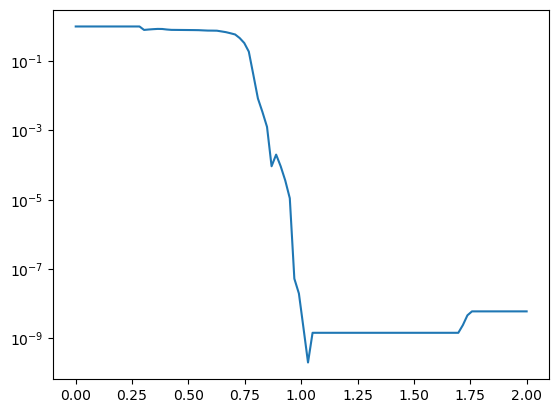

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6d00b1790>

In [195]:
using Interpolations
Gurobi_time = 7/24:1/24:2
# Gurobi_time = [20/11:1/11:3;19/6:1/6:25/6]
# Gurobi_time = Gurobi_time[1:22]

# Gurobi_time = range(0.04,stop=0.52,length=14)
# Gurobi_time = range(0.34,stop=3.14,length=14)
# Gurobi_time = Gurobi_time[1:18]

Gurobi_obj = Gurobi_obj[1:42]
# Gurobi_obj = Gurobi_obj[1:21]
# Gurobi_obj = Gurobi_obj[1:22]

# Gurobi_obj = Gurobi_obj[1:14]
# Gurobi_obj = Gurobi_obj[1:14]
# Gurobi_obj = Gurobi_obj[1:18]


itp_Gurobi = linear_interpolation(Gurobi_time, Gurobi_obj)

a1 = Gurobi_time[1]
b1 = 2
function f1_itp(x)
    if x>= a1 && x<= b1
        return itp_Gurobi(x) 
    end
    if x>=0 && x<a1
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time1= range(0,stop=b1,length=100)
PyPlot.semilogy(time1, [abs(f1_itp(i)-r1_long[100000])/abs(f1_itp(0)-r1_long[100000]) for i in time1])

In [133]:
# y2 = Variable(n)
# Prob = minimize(0.5*quadform(y2,Q; assume_psd=true)+dot(c,y2)-1, norm(A*y2 - b, 2) <= 1)
# @time Convex.solve!(Prob, Mosek.Optimizer)
# # z = evaluate(y2)

model = Model(Mosek.Optimizer)
# set_optimizer_attribute(model, "Presolve", 0)

JuMP.@variable(model, y[1:n])
JuMP.@objective(model, Min, 0.5*y'*Q*y + c'*y - 1.0)
JuMP.@constraint(model, [1; A*y-b] in SecondOrderCone())
@time optimize!(model)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 0               
  Affine conic cons.     : 2               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 1601            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.02            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.40    
Problem
  Name                   :                 
  Obj

In [196]:
str2 =
"
0   1.2e+01  3.0e+00  2.5e+00  0.00e+00   -1.000000000e+00  -2.500000000e+00  1.0e+00  0.09  
1   4.0e-01  9.6e-02  4.4e-01  -1.00e+00  1.153963145e+01   3.921701264e+01   3.2e-02  0.11  
2   3.1e-02  7.5e-03  1.1e-01  -9.98e-01  2.376441200e+02   5.528547101e+02   2.5e-03  0.13  
3   2.9e-03  6.9e-04  2.6e-02  -9.73e-01  3.212971812e+03   5.301783131e+03   2.3e-04  0.15  
4   2.1e-04  5.1e-05  1.6e-03  -6.50e-01  1.632024920e+04   1.762659258e+04   1.7e-05  0.16  
5   4.0e-06  9.6e-07  2.5e-06  1.03e+00   1.775254452e+04   1.776179783e+04   3.2e-07  0.17  
6   1.7e-07  4.1e-08  2.1e-08  1.00e+00   1.775861429e+04   1.775897640e+04   1.4e-08  0.19  
7   2.6e-09  6.2e-10  3.8e-11  1.00e+00   1.775873152e+04   1.775873674e+04   2.1e-10  0.21  
8   3.3e-10  2.0e-10  4.8e-13  1.00e+00   1.775873243e+04   1.775873244e+04   6.4e-13  0.22  
9   3.3e-10  2.0e-10  4.8e-13  1.00e+00   1.775873243e+04   1.775873244e+04   6.4e-13  0.25  
10  3.3e-10  2.0e-10  4.8e-13  1.00e+00   1.775873243e+04   1.775873244e+04   6.4e-13  0.28  
"
# "
# 0   2.4e+01  3.5e+00  2.5e+00  0.00e+00   -1.000000000e+00  -2.500000000e+00  1.0e+00  0.57  
# 1   7.7e-01  1.1e-01  4.4e-01  -1.00e+00  1.149348283e+01   3.923716774e+01   3.2e-02  0.66  
# 2   6.0e-02  8.7e-03  1.1e-01  -9.99e-01  2.396191308e+02   5.622563245e+02   2.5e-03  0.72  
# 3   5.5e-03  8.0e-04  2.8e-02  -9.93e-01  3.418883169e+03   5.861663579e+03   2.3e-04  0.80  
# 4   4.9e-04  7.1e-05  5.2e-03  -9.17e-01  3.746988019e+04   4.783583722e+04   2.0e-05  0.87  
# 5   5.1e-05  7.4e-06  1.4e-04  1.22e-01   7.221902616e+04   7.289872108e+04   2.1e-06  0.94  
# 6   1.4e-06  2.0e-07  4.3e-07  1.08e+00   7.104764074e+04   7.105635207e+04   5.8e-08  0.99  
# 7   6.0e-08  8.7e-09  2.8e-09  1.00e+00   7.101189752e+04   7.101209600e+04   2.5e-09  1.05  
# 8   8.0e-09  3.9e-10  2.4e-11  1.01e+00   7.101036991e+04   7.101037853e+04   9.7e-11  1.10  
# 9   1.6e-09  1.0e-10  5.8e-13  -5.88e-01  7.101025778e+04   7.101025854e+04   4.7e-12  1.16  
# 10  1.4e-09  1.1e-10  1.5e-13  7.63e-01   7.101025989e+04   7.101026058e+04   4.0e-12  1.25  
# 11  1.4e-09  1.1e-10  1.0e-13  8.03e-01   7.101025993e+04   7.101026061e+04   4.0e-12  1.36  
# 12  1.2e-09  1.2e-10  7.4e-14  6.99e-01   7.101026184e+04   7.101026246e+04   3.5e-12  1.44  
# 13  1.2e-09  1.2e-10  7.9e-14  6.62e-01   7.101026184e+04   7.101026246e+04   3.5e-12  1.54  
# 14  1.2e-09  1.2e-10  6.6e-14  7.25e-01   7.101026187e+04   7.101026249e+04   3.4e-12  1.70  
# 15  1.2e-09  1.3e-10  8.3e-14  6.63e-01   7.101026189e+04   7.101026251e+04   3.4e-12  1.84  
# 16  1.2e-09  1.2e-10  4.7e-14  7.60e-01   7.101026190e+04   7.101026251e+04   3.4e-12  1.95  
# 17  1.2e-09  1.2e-10  4.7e-14  7.60e-01   7.101026190e+04   7.101026251e+04   3.4e-12  2.07  
# 18  1.2e-09  1.3e-10  7.8e-14  7.48e-01   7.101026212e+04   7.101026273e+04   3.4e-12  2.15  
# 19  1.1e-09  1.4e-10  6.1e-15  7.35e-01   7.101026300e+04   7.101026358e+04   3.2e-12  2.26  
# 20  9.8e-10  1.8e-10  4.9e-15  7.21e-01   7.101026468e+04   7.101026520e+04   2.7e-12  2.38  
# 21  9.7e-10  1.8e-10  8.2e-15  7.67e-01   7.101026487e+04   7.101026538e+04   2.7e-12  2.49  
# 22  8.5e-10  2.3e-10  1.7e-14  7.70e-01   7.101026641e+04   7.101026686e+04   2.3e-12  2.57  
# 23  7.4e-10  2.8e-10  7.1e-14  7.65e-01   7.101026779e+04   7.101026820e+04   2.0e-12  2.64  
# 24  7.4e-10  2.8e-10  1.9e-14  8.32e-01   7.101026779e+04   7.101026820e+04   2.0e-12  2.76  
# 25  7.4e-10  2.8e-10  1.9e-14  8.32e-01   7.101026779e+04   7.101026820e+04   2.0e-12  2.87  
# 26  6.4e-10  3.2e-10  8.0e-14  8.02e-01   7.101026905e+04   7.101026942e+04   1.8e-12  2.97  
# 27  6.4e-10  3.2e-10  2.5e-14  7.84e-01   7.101026909e+04   7.101026945e+04   1.8e-12  3.08  
# 28  6.4e-10  3.2e-10  2.5e-14  7.84e-01   7.101026909e+04   7.101026945e+04   1.8e-12  3.22  
# 29  3.3e-10  3.8e-10  7.1e-14  1.18e+00   7.101027332e+04   7.101027354e+04   1.1e-12  3.34  
# 30  3.3e-10  3.8e-10  7.1e-14  1.18e+00   7.101027332e+04   7.101027354e+04   1.1e-12  3.41  
# 31  3.3e-10  3.8e-10  7.1e-14  1.18e+00   7.101027332e+04   7.101027354e+04   1.1e-12  3.49  
# "
# "
# 0   3.4e+01  3.7e+00  2.5e+00  0.00e+00   -1.000000000e+00  -2.500000000e+00  1.0e+00  3.00  
# 1   1.1e+00  1.2e-01  4.4e-01  -1.00e+00  1.151229810e+01   3.927049185e+01   3.2e-02  3.31  
# 2   8.5e-02  9.3e-03  1.1e-01  -1.00e+00  2.405562866e+02   5.651275604e+02   2.5e-03  3.62  
# 3   7.7e-03  8.5e-04  2.9e-02  -9.98e-01  3.488000764e+03   6.051168946e+03   2.3e-04  3.94  
# 4   7.5e-04  8.2e-05  6.2e-03  -9.80e-01  4.312527668e+04   5.591270452e+04   2.2e-05  4.25  
# 5   1.0e-04  1.2e-05  1.4e-03  -7.66e-01  2.174761898e+05   2.521263117e+05   3.1e-06  4.50  
# 6   1.1e-05  1.2e-06  3.0e-05  6.62e-01   2.965988168e+05   2.980172489e+05   3.2e-07  4.72  
# 7   1.2e-07  1.4e-08  3.4e-08  1.03e+00   2.950917366e+05   2.951059746e+05   3.7e-09  5.03  
# 8   2.3e-09  2.2e-10  5.6e-11  1.00e+00   2.950647732e+05   2.950649781e+05   6.0e-11  5.24  
# 9   2.3e-09  2.2e-10  5.6e-11  1.00e+00   2.950647732e+05   2.950649781e+05   6.0e-11  5.62  
# 10  1.9e-10  6.5e-11  5.8e-12  9.97e-01   2.950642771e+05   2.950642812e+05   1.0e-12  5.96  
# 11  8.9e-11  5.9e-11  2.1e-12  -1.04e+00  2.950642771e+05   2.950642792e+05   5.5e-13  6.28  
# 12  9.5e-12  9.9e-11  2.4e-13  9.08e-01   2.950642784e+05   2.950642794e+05   3.1e-13  6.59  
# 13  9.4e-12  8.5e-11  2.1e-13  6.66e-01   2.950642784e+05   2.950642794e+05   3.1e-13  6.95  
# 14  9.4e-12  8.5e-11  2.1e-13  6.66e-01   2.950642784e+05   2.950642794e+05   3.1e-13  7.44  
# 15  9.4e-12  8.5e-11  2.1e-13  6.66e-01   2.950642784e+05   2.950642794e+05   3.1e-13  7.99  
# "

# "
# 0   5.0e+01  6.5e-01  3.4e+00  0.00e+00   -2.928932188e-01  -2.707106781e+00  1.0e+00  0.06  
# 1   1.8e-02  2.4e-04  5.9e-02  -1.00e+00  1.524028460e+03   3.658621525e+03   3.7e-04  0.065  
# 2   2.4e-03  3.1e-05  7.9e-03  -5.72e-01  1.011392886e+04   1.246425262e+04   4.8e-05  0.07  
# 3   1.0e-04  1.4e-06  1.0e-04  4.71e-01   1.736401707e+04   1.757892775e+04   2.1e-06  0.08  
# 4   8.2e-06  1.1e-07  1.5e-06  9.77e-01   1.773834866e+04   1.774499704e+04   1.7e-07  0.09  
# 5   2.1e-08  2.7e-10  8.2e-11  9.98e-01   1.775868513e+04   1.775868856e+04   4.2e-10  0.10  
# 6   7.4e-10  1.4e-12  8.1e-13  1.00e+00   1.775873231e+04   1.775873232e+04   1.4e-12  0.11  
# "
# "
# 0   9.6e+01  5.4e-01  3.4e+00  0.00e+00   -2.928932188e-01  -2.707106781e+00  1.0e+00  0.29  
# 1   2.4e-02  1.3e-04  5.2e-02  -1.00e+00  2.561649707e+03   6.186665739e+03   2.5e-04  0.36  
# 2   2.0e-03  1.1e-05  6.9e-03  -8.23e-01  3.104313213e+04   4.059815593e+04   2.1e-05  0.41  
# 3   4.4e-05  2.4e-07  4.3e-05  1.99e-01   6.952977677e+04   7.031596409e+04   4.5e-07  0.46  
# 4   1.9e-06  1.0e-08  2.3e-07  9.80e-01   7.097205881e+04   7.098453005e+04   1.9e-08  0.49  
# 5   5.9e-09  3.3e-11  6.5e-12  9.99e-01   7.101016592e+04   7.101016648e+04   6.1e-11  0.53  
# 6   3.1e-09  1.7e-11  3.8e-12  1.00e+00   7.101022063e+04   7.101022091e+04   3.2e-11  0.60  
# 7   1.6e-09  8.8e-12  8.0e-13  1.00e+00   7.101024935e+04   7.101024950e+04   1.6e-11  0.63  
# 8   1.6e-09  8.8e-12  8.0e-13  1.00e+00   7.101024935e+04   7.101024950e+04   1.6e-11  0.71  
# 9   1.5e-09  8.2e-12  1.3e-13  1.00e+00   7.101025121e+04   7.101025136e+04   1.5e-11  0.75  
# 10  1.5e-09  8.1e-12  2.8e-13  1.00e+00   7.101025165e+04   7.101025179e+04   1.5e-11  0.81  
# 11  1.4e-09  8.0e-12  9.5e-14  1.00e+00   7.101025186e+04   7.101025201e+04   1.5e-11  0.86  
# 12  1.4e-09  8.0e-12  9.5e-14  1.00e+00   7.101025186e+04   7.101025201e+04   1.5e-11  0.93  
# 13  1.4e-09  8.0e-12  9.5e-14  1.00e+00   7.101025186e+04   7.101025201e+04   1.5e-11  0.99  
# "
# "
# 0   1.4e+02  6.3e-01  3.4e+00  0.00e+00   -2.928932188e-01  -2.707106781e+00  1.0e+00  1.31  
# 1   1.5e-02  6.9e-05  3.5e-02  -1.00e+00  6.125937165e+03   1.478715629e+04   1.1e-04  1.56  
# 2   1.1e-03  4.9e-06  5.4e-03  -8.99e-01  9.171214040e+04   1.333628804e+05   7.7e-06  1.79  
# 3   2.9e-05  1.3e-07  5.6e-05  -4.29e-02  2.812826025e+05   2.872386544e+05   2.1e-07  1.98  
# 4   5.4e-06  2.5e-08  3.7e-06  9.59e-01   2.932120581e+05   2.939413261e+05   4.0e-08  2.16  
# 5   1.4e-07  6.3e-10  1.5e-08  9.92e-01   2.950068770e+05   2.950261554e+05   1.0e-09  2.32  
# 6   5.7e-10  2.6e-12  3.7e-11  1.00e+00   2.950640864e+05   2.950641580e+05   4.1e-12  2.53  
# 7   3.8e-09  9.4e-13  9.4e-13  1.00e+00   2.950642749e+05   2.950642755e+05   3.8e-14  2.79  
# 8   8.5e-09  7.1e-13  3.5e-13  1.00e+00   2.950642752e+05   2.950642757e+05   2.9e-14  3.10  
# 9   8.5e-09  7.1e-13  3.5e-13  1.00e+00   2.950642752e+05   2.950642757e+05   2.9e-14  3.42  
# 10  8.5e-09  7.1e-13  3.5e-13  1.00e+00   2.950642752e+05   2.950642757e+05   2.9e-14  3.77  
# "
Mosek_obj, Mosek_time = extract_vectors(str2, 6, 9)

([-1.0, 11.53963145, 237.64412, 3212.971812, 16320.2492, 17752.54452, 17758.61429, 17758.73152, 17758.73243, 17758.73243, 17758.73243], [0.09, 0.11, 0.13, 0.15, 0.16, 0.17, 0.19, 0.21, 0.22, 0.25, 0.28])

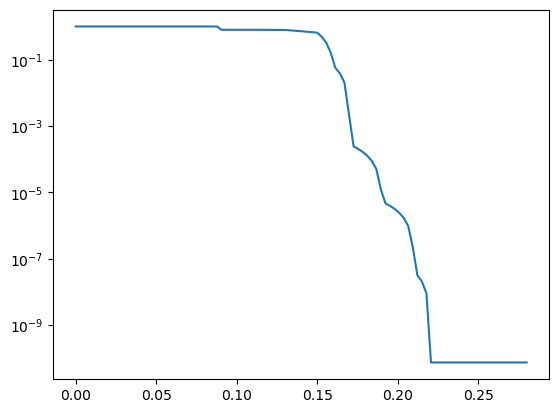

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6d01841c0>

In [197]:

itp_mosek = linear_interpolation(Mosek_time, Mosek_obj)
a2 = Mosek_time[1]
b2 = 0.28

function f2_itp(x)
    if x>= a2 && x<= b2
        return itp_mosek(x) 
    end
    if x>=0 && x<a2
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time2= range(0,stop=b2,length=100)
PyPlot.semilogy(time2, [abs(f2_itp(i)-r1_long[100000])/abs(f2_itp(0)-r1_long[100000]) for i in time2])

In [766]:
r3_long[100000]

295064.27640198753

In [138]:
# y3 = Variable(n)
# Prob = minimize(0.5*quadform(y3,Q; assume_psd=true)+dot(c,y3)-1, norm(A*y3 - b, 2) <= 1)
# @time Convex.solve!(Prob, MOI.OptimizerWithAttributes(COSMO.Optimizer))
# # @time Convex.solve!(Prob, SCS.Optimizer)
# # z = evaluate(y3)


model = Model(COSMO.Optimizer)
# set_optimizer_attribute(model, "Presolve", 0)

JuMP.@variable(model, y[1:n])
JuMP.@objective(model, Min, 0.5*y'*Q*y + c'*y - 1.0)
JuMP.@constraint(model, [1; A*y-b] in SecondOrderCone())
@time optimize!(model)

------------------------------------------------------------------
          COSMO v0.8.7 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{1600},
          constraints: A ∈ R^{801x1600} (1280000 nnz),
          matrix size to factor: 2401x2401,
          Floating-point precision: Float64
Sets:     SecondOrderCone of dim: 801
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 4096.67ms

Iter:	Objective:	Primal Res:	Dual Res:	Rho:
1

In [198]:
str3 = 
"
1	-1.7854e+02	1.8825e+02	2.4062e+00	1.0000e-01
25	 1.0255e+03	2.7640e+01	2.1965e+00	1.0000e-01
50	 5.4721e+03	1.5354e+01	1.2957e-01	4.9420e-03
75	 5.8333e+03	5.0275e+00	2.5943e-03	4.9420e-03
100	 5.8790e+03	2.0322e+00	5.4996e-04	4.9420e-03
125	 5.8728e+03	9.8925e+00	1.7568e-02	4.9420e-03
150	 5.8907e+03	1.0290e+01	4.6698e-03	4.9420e-03
175	 5.9315e+03	1.9278e+00	8.3076e-04	4.9420e-03
200	 6.0233e+03	2.0135e+00	1.0574e-03	4.9420e-03
225	 6.1039e+03	2.4503e+00	8.2654e-04	4.9420e-03
250	 6.1571e+03	1.7988e+00	6.5328e-04	4.9420e-03
275	 6.2597e+03	1.8046e+00	7.1475e-05	4.9420e-03
300	 6.2994e+03	1.7834e+00	3.6956e-05	4.9420e-03
325	 6.3062e+03	1.7333e+00	2.3634e-04	4.9420e-03
350	 6.3646e+03	1.7236e+00	1.2303e-04	4.9420e-03
375	 6.4139e+03	1.6952e+00	6.0367e-04	4.9420e-03
400	 6.4712e+03	1.6793e+00	2.9044e-04	4.9420e-03
425	 6.5119e+03	1.6953e+00	2.3440e-05	4.9420e-03
450	 6.5699e+03	1.6756e+00	4.0961e-06	4.9420e-03
475	 6.5682e+03	1.6377e+00	6.7311e-05	4.9420e-03
500	 6.6142e+03	1.6192e+00	1.9893e-04	4.9420e-03
525	 6.6654e+03	1.6776e+00	1.4286e-03	4.9420e-03
550	 6.7140e+03	1.5849e+00	2.9950e-04	4.9420e-03
575	 6.7610e+03	1.6015e+00	1.8726e-05	4.9420e-03
600	 6.8091e+03	1.5818e+00	1.6965e-05	4.9420e-03
625	 7.0772e+03	1.4979e+00	5.8176e-04	4.9420e-03
650	 7.0589e+03	1.5026e+00	2.0036e-03	4.9420e-03
675	 7.1602e+03	3.7783e+00	2.9066e-03	4.9420e-03
700	 7.1134e+03	1.4605e+00	3.9615e-05	4.9420e-03
725	 7.1341e+03	1.4674e+00	2.0141e-04	4.9420e-03
750	 7.2501e+03	1.4541e+00	4.8589e-04	4.9420e-03
775	 7.2333e+03	1.4241e+00	2.6277e-04	4.9420e-03
800	 7.2509e+03	1.4251e+00	1.3327e-04	4.9420e-03
825	 7.3031e+03	1.4208e+00	3.8034e-05	4.9420e-03
850	 7.2869e+03	1.4033e+00	1.8804e-04	4.9420e-03
875	 7.2982e+03	1.4041e+00	3.1279e-04	4.9420e-03
900	 7.3311e+03	1.4107e+00	1.5248e-04	4.9420e-03
925	 7.3314e+03	1.3894e+00	4.8648e-04	4.9420e-03
950	 7.3402e+03	1.3889e+00	2.7979e-04	4.9420e-03
975	 7.3956e+03	1.3812e+00	9.4040e-04	4.9420e-03
1000	 7.4156e+03	1.3614e+00	2.5343e-04	4.9420e-03
1025	 7.4460e+03	1.3689e+00	5.9765e-05	4.9420e-03
1050	 7.5075e+03	1.3477e+00	2.4229e-05	4.9420e-03
1075	 7.5040e+03	1.3288e+00	1.1234e-04	4.9420e-03
1100	 7.5448e+03	1.3114e+00	8.7378e-05	4.9420e-03
1125	 7.5847e+03	1.3144e+00	1.1215e-03	4.9420e-03
1150	 7.6245e+03	1.2905e+00	1.6358e-04	4.9420e-03
1175	 7.6245e+03	1.2933e+00	1.3061e-04	4.9420e-03
1200	 7.6635e+03	1.2778e+00	1.1430e-04	4.9420e-03
1225	 7.7035e+03	1.2690e+00	9.5199e-05	4.9420e-03
1250	 7.7430e+03	1.2788e+00	4.8267e-06	4.9420e-03
1275	 7.7793e+03	1.2681e+00	1.8677e-05	4.9420e-03
1300	 7.8227e+03	1.2354e+00	4.1340e-05	4.9420e-03
1325	 7.8602e+03	1.2247e+00	4.5837e-05	4.9420e-03
1350	 7.8954e+03	1.2171e+00	1.6369e-04	4.9420e-03
1375	 7.9321e+03	1.2055e+00	4.1894e-05	4.9420e-03
"
# "
# 1	-5.1457e+02	3.5176e+02	2.8354e+00	1.0000e-01
# 25	 1.8868e+03	3.7368e+01	3.1791e+00	1.0000e-01
# 50	 7.0417e+03	4.4476e+01	1.2628e+00	3.4081e-03
# 75	 9.6071e+03	4.9899e+01	1.8795e-02	3.4081e-03
# 100	 9.3469e+03	5.3503e+01	8.8645e-03	3.4081e-03
# 125	 9.4277e+03	4.7908e+01	1.6321e-02	3.4081e-03
# 150	 1.2825e+04	4.3774e+00	2.1917e-03	3.4081e-03
# 175	 1.2832e+04	4.3781e+00	2.1558e-03	3.4081e-03
# 200	 1.2840e+04	4.3788e+00	2.1181e-03	3.4081e-03
# 225	 1.2848e+04	4.3793e+00	2.0788e-03	3.4081e-03
# 250	 1.2855e+04	4.3798e+00	2.0378e-03	3.4081e-03
# 275	 1.2862e+04	4.3802e+00	1.9952e-03	3.4081e-03
# 300	 1.2869e+04	4.3805e+00	1.9509e-03	3.4081e-03
# 325	 1.2876e+04	4.3808e+00	1.9052e-03	3.4081e-03
# 350	 1.2883e+04	4.3809e+00	1.8581e-03	3.4081e-03
# 375	 1.2890e+04	4.3810e+00	1.8096e-03	3.4081e-03
# 400	 1.2896e+04	4.3810e+00	1.7599e-03	3.4081e-03
# 425	 1.2902e+04	4.3809e+00	1.7091e-03	3.4081e-03
# 450	 1.2908e+04	4.3807e+00	1.6572e-03	3.4081e-03
# 475	 1.2914e+04	4.3804e+00	1.6046e-03	3.4081e-03
# 500	 1.2920e+04	4.3800e+00	1.5512e-03	3.4081e-03
# 525	 1.2925e+04	4.3795e+00	1.4972e-03	3.4081e-03
# 550	 1.2931e+04	4.3790e+00	1.4428e-03	3.4081e-03
# 575	 1.2936e+04	4.3784e+00	1.3881e-03	3.4081e-03
# 600	 1.2941e+04	4.3776e+00	1.3333e-03	3.4081e-03
# 625	 1.2945e+04	4.3768e+00	1.2786e-03	3.4081e-03
# 650	 1.2950e+04	4.3760e+00	1.2240e-03	3.4081e-03
# 675	 1.2954e+04	4.3750e+00	1.1697e-03	3.4081e-03
# 700	 1.2958e+04	4.3740e+00	1.1159e-03	3.4081e-03
# 725	 1.2962e+04	4.3729e+00	1.0628e-03	3.4081e-03
# 750	 1.2966e+04	4.3717e+00	1.0105e-03	3.4081e-03
# 775	 1.2969e+04	4.3705e+00	9.5917e-04	3.4081e-03
# 800	 1.2973e+04	4.3692e+00	9.0891e-04	3.4081e-03
# 825	 1.2976e+04	4.3678e+00	8.5988e-04	3.4081e-03
# 850	 1.2979e+04	4.3664e+00	8.1223e-04	3.4081e-03
# 875	 1.2982e+04	4.3649e+00	7.6607e-04	3.4081e-03
# 900	 1.2985e+04	4.3634e+00	7.2153e-04	3.4081e-03
# 925	 1.2987e+04	4.3618e+00	6.7874e-04	3.4081e-03
# 950	 1.2989e+04	4.3602e+00	6.3779e-04	3.4081e-03
# 975	 1.2992e+04	4.3586e+00	5.9878e-04	3.4081e-03
# 1000	 1.2994e+04	4.3569e+00	5.6182e-04	3.4081e-03
# 1025	 1.2996e+04	4.3552e+00	5.2698e-04	3.4081e-03
# 1050	 1.2997e+04	4.3535e+00	4.9435e-04	3.4081e-03
# 1075	 1.2999e+04	4.3518e+00	4.6397e-04	3.4081e-03
# 1100	 1.3001e+04	4.3500e+00	4.3593e-04	3.4081e-03
# 1125	 1.3002e+04	4.3482e+00	4.1025e-04	3.4081e-03
# 1150	 1.3004e+04	4.3464e+00	3.8699e-04	3.4081e-03
# 1175	 1.3005e+04	4.3447e+00	3.6617e-04	3.4081e-03
# 1200	 1.3006e+04	4.3429e+00	3.4781e-04	3.4081e-03
# 1225	 1.3008e+04	4.3411e+00	3.3191e-04	3.4081e-03
# 1250	 1.3009e+04	4.3393e+00	3.1849e-04	3.4081e-03
# 1275	 1.3010e+04	4.3375e+00	3.0754e-04	3.4081e-03
# 1300	 1.3011e+04	4.3358e+00	2.9903e-04	3.4081e-03
# 1325	 1.3012e+04	4.3341e+00	2.9294e-04	3.4081e-03
# 1350	 1.3013e+04	4.3323e+00	2.8923e-04	3.4081e-03
# 1375	 1.3014e+04	4.3306e+00	2.8787e-04	3.4081e-03
# 1400	 1.3015e+04	4.3290e+00	2.8879e-04	3.4081e-03
# 1425	 1.3016e+04	4.3274e+00	2.9194e-04	3.4081e-03
# 1450	 1.3017e+04	4.3258e+00	2.9726e-04	3.4081e-03
# 1475	 1.3018e+04	4.3242e+00	3.0467e-04	3.4081e-03
# 1500	 1.3019e+04	4.3227e+00	3.1408e-04	3.4081e-03
# 1525	 1.3021e+04	4.3213e+00	3.2541e-04	3.4081e-03
# 1550	 1.3022e+04	4.3198e+00	3.3857e-04	3.4081e-03
# 1575	 1.3023e+04	4.3184e+00	3.5346e-04	3.4081e-03
# 1600	 1.3024e+04	4.3171e+00	3.6997e-04	3.4081e-03
# 1625	 1.3077e+04	4.2681e+00	1.1618e-03	3.4081e-03
# 1650	 1.3233e+04	4.2121e+00	1.4242e-03	3.4081e-03
# 1675	 1.3240e+04	4.1996e+00	6.4245e-04	3.4081e-03
# 1700	 1.3260e+04	4.2031e+00	9.5563e-04	3.4081e-03
# 1725	 1.3467e+04	4.1561e+00	1.8100e-03	3.4081e-03
# "
# "
# 1	-5.6763e+02	6.5932e+02	2.9574e+00	1.0000e-01
# 25	 2.3098e+04	2.0891e+01	1.5253e+00	1.0000e-01
# 50	 7.5539e+04	1.3776e+01	1.5461e-01	1.3283e-03
# 75	 8.5854e+04	2.4219e+00	9.0125e-05	1.3283e-03
# 100	 8.5855e+04	2.4188e+00	9.8018e-05	1.3283e-03
# 125	 8.5856e+04	2.4189e+00	1.0574e-04	1.3283e-03
# 150	 8.5857e+04	2.4189e+00	1.1342e-04	1.3283e-03
# 175	 8.5858e+04	2.4190e+00	1.2106e-04	1.3283e-03
# 200	 8.5859e+04	2.4191e+00	1.2866e-04	1.3283e-03
# 225	 8.5860e+04	2.4191e+00	1.3621e-04	1.3283e-03
# 250	 8.5862e+04	2.4192e+00	1.4371e-04	1.3283e-03
# 275	 8.5863e+04	2.4193e+00	1.5117e-04	1.3283e-03
# 300	 8.5865e+04	2.4194e+00	1.5857e-04	1.3283e-03
# 325	 8.5866e+04	2.4194e+00	1.6592e-04	1.3283e-03
# 350	 8.5868e+04	2.4195e+00	1.7321e-04	1.3283e-03
# 375	 8.5869e+04	2.4196e+00	1.8044e-04	1.3283e-03
# 400	 8.5871e+04	2.4197e+00	1.8761e-04	1.3283e-03
# 425	 8.5873e+04	2.4198e+00	1.9473e-04	1.3283e-03
# 450	 8.5875e+04	2.4199e+00	2.0177e-04	1.3283e-03
# 475	 8.5876e+04	2.4200e+00	2.0876e-04	1.3283e-03
# 500	 8.5878e+04	2.4201e+00	2.1567e-04	1.3283e-03
# 525	 8.5880e+04	2.4202e+00	2.2252e-04	1.3283e-03
# 550	 8.5883e+04	2.4203e+00	2.2929e-04	1.3283e-03
# 575	 8.5885e+04	2.4204e+00	2.3600e-04	1.3283e-03
# 600	 8.5887e+04	2.4205e+00	2.4262e-04	1.3283e-03
# 625	 8.5889e+04	2.4206e+00	2.4918e-04	1.3283e-03
# 650	 8.5892e+04	2.4207e+00	2.5565e-04	1.3283e-03
# 675	 8.5894e+04	2.4208e+00	2.6204e-04	1.3283e-03
# 700	 8.5896e+04	2.4209e+00	2.6836e-04	1.3283e-03
# 725	 8.5899e+04	2.4210e+00	2.7459e-04	1.3283e-03
# 750	 8.5901e+04	2.4211e+00	2.8073e-04	1.3283e-03
# "


# "
# 1	 2.4774e+04	3.2150e+01	3.3543e+02	1.0000e-01
# 25	 1.7760e+04	2.8233e-10	5.5540e-10	1.0000e-01
# "

# "
# 1	 1.1821e+05	5.3853e+01	8.2810e+02	1.0000e-01
# 25	 7.1570e+04	1.0000e+00	2.9605e-06	1.0000e-01
# 50	 7.1556e+04	3.2742e-01	1.2876e+03	1.0190e+03
# 75	 7.1383e+04	9.3087e-07	1.2860e+03	1.0190e+03
# 100	 7.1011e+04	3.8869e-06	1.9123e-05	2.7924e-02
# "

# "
# 1	 5.9032e+05	7.8442e+01	1.8074e+03	1.0000e-01
# 25	 2.9614e+05	1.0000e+00	2.7947e-05	1.0000e-01
# 50	 2.9614e+05	1.0000e+00	6.2101e-11	8.5610e+02
# 75	 2.9614e+05	1.0000e+00	2.3382e-11	8.5610e+02
# 100	 2.9614e+05	1.0000e+00	9.5167e-04	1.0000e+06
# 125	 2.9614e+05	1.0000e+00	4.7222e-07	1.0000e+06
# 150	 2.9614e+05	1.0000e+00	1.8979e-11	1.0000e+06
# 175	 2.9614e+05	1.0000e+00	1.7462e-11	1.0000e+06
# 200	 2.9614e+05	1.0000e+00	5.5612e-11	1.0000e+06
# 225	 2.9613e+05	1.0000e+00	3.5811e+05	1.0000e+06
# 250	 2.9614e+05	1.0000e+00	1.7946e-09	1.0000e+06
# 275	 2.9614e+05	1.0000e+00	4.5267e-11	1.0000e+06
# 300	 2.9614e+05	1.0000e+00	3.4182e-11	1.0000e+06
# 325	 2.9614e+05	1.0000e+00	2.4983e-11	1.0000e+06
# 350	 2.9614e+05	1.0000e+00	1.6901e-11	1.0000e+06
# 375	 2.9614e+05	1.0000e+00	2.4309e-11	1.0000e+06
# 400	 2.9614e+05	1.0000e+00	3.2069e-11	1.0000e+06
# 425	 2.9614e+05	1.0000e+00	1.7338e-11	1.0000e+06
# 450	 2.9614e+05	1.0000e+00	1.7086e-11	1.0000e+06
# 475	 2.9614e+05	1.0000e+00	3.0504e-11	1.0000e+06
# 500	 2.9614e+05	1.0000e+00	1.1898e-10	1.0000e+06
# 525	 2.9614e+05	1.0000e+00	1.9025e-11	1.0000e+06
# 550	 2.9614e+05	1.0000e+00	6.6874e-11	1.0000e+06
# 575	 2.9614e+05	1.0000e+00	3.3292e-11	1.0000e+06
# 600	 2.9614e+05	1.0000e+00	2.2725e-11	1.0000e+06
# 625	 2.9614e+05	1.0000e+00	2.2782e-11	1.0000e+06
# 650	 2.9614e+05	1.0000e+00	2.2472e-11	1.0000e+06
# 675	 2.9614e+05	1.0000e+00	4.1484e-11	1.0000e+06
# 700	 2.9614e+05	1.0000e+00	4.6039e-11	1.0000e+06
# 725	 2.9614e+05	1.0000e+00	2.5906e-11	1.0000e+06
# 750	 2.9614e+05	1.0000e+00	1.7769e-11	1.0000e+06
# 775	 2.9614e+05	1.0000e+00	7.9404e-11	1.0000e+06
# 800	 2.9614e+05	1.0000e+00	2.1413e-11	1.0000e+06
# 825	 2.9614e+05	1.0000e+00	5.6149e-11	1.0000e+06
# 850	 2.9614e+05	1.0000e+00	4.0424e-11	1.0000e+06
# 875	 2.9614e+05	1.0000e+00	1.7074e-11	1.0000e+06
# 900	 2.9614e+05	1.0000e+00	1.7748e-11	1.0000e+06
# 925	 2.9614e+05	1.0000e+00	6.4029e-11	1.0000e+06
# 950	 2.9614e+05	1.0000e+00	7.1417e-11	1.0000e+06
# 975	 2.9614e+05	1.0000e+00	2.1712e-11	1.0000e+06
# 1000	 2.9614e+05	1.0000e+00	2.3738e-11	1.0000e+06
# 1025	 2.9614e+05	1.0000e+00	3.6209e-11	1.0000e+06
# 1050	 2.9614e+05	1.0000e+00	2.0525e-11	1.0000e+06
# 1075	 2.9614e+05	1.0000e+00	1.6703e-11	1.0000e+06
# 1100	 2.9614e+05	1.0000e+00	1.8474e-11	1.0000e+06
# 1125	 2.9614e+05	1.0000e+00	2.7201e-11	1.0000e+06
# 1150	 2.9614e+05	1.0000e+00	3.6059e-11	1.0000e+06
# 1175	 2.9614e+05	1.0000e+00	4.1769e-11	1.0000e+06
# 1200	 2.9614e+05	1.0000e+00	3.1234e-11	1.0000e+06
# 1225	 2.9614e+05	1.0000e+00	1.4212e-11	1.0000e+06
# 1250	 2.9614e+05	1.0000e+00	2.4346e-11	1.0000e+06
# 1275	 2.9614e+05	1.0000e+00	7.9621e-11	1.0000e+06
# 1300	 2.9614e+05	1.0000e+00	1.6508e-11	1.0000e+06
# 1325	 2.9614e+05	1.0000e+00	3.0433e-11	1.0000e+06
# 1350	 2.9614e+05	1.0000e+00	1.8602e-11	1.0000e+06
# 1375	 2.9614e+05	1.0000e+00	2.1728e-11	1.0000e+06
# 1400	 2.9614e+05	1.0000e+00	3.3583e-11	1.0000e+06
# 1425	 2.9614e+05	1.0000e+00	4.0868e-11	1.0000e+06
# 1450	 2.9614e+05	1.0000e+00	2.2294e-11	1.0000e+06
# 1475	 2.9614e+05	1.0000e+00	2.1133e-11	1.0000e+06
# 1500	 2.9614e+05	1.0000e+00	4.9920e-11	1.0000e+06
# 1525	 2.9614e+05	1.0000e+00	1.7214e-11	1.0000e+06
# 1550	 2.9614e+05	1.0000e+00	3.8061e-11	1.0000e+06
# 1575	 2.9614e+05	1.0000e+00	3.3538e-11	1.0000e+06
# 1600	 2.9614e+05	1.0000e+00	2.3869e-11	1.0000e+06
# 1625	 2.9614e+05	1.0000e+00	2.0661e-11	1.0000e+06
# 1650	 2.9614e+05	1.0000e+00	1.4799e-11	1.0000e+06
# 1675	 2.9614e+05	1.0000e+00	4.2407e-11	1.0000e+06
# 1700	 2.9614e+05	1.0000e+00	3.2067e-11	1.0000e+06
# 1725	 2.9614e+05	1.0000e+00	1.4438e-11	1.0000e+06
# 1750	 2.9614e+05	1.0000e+00	2.9867e-11	1.0000e+06
# 1775	 2.9614e+05	1.0000e+00	7.9074e-11	1.0000e+06
# 1800	 2.9614e+05	1.0000e+00	5.8767e-11	1.0000e+06
# 1825	 2.9614e+05	1.0000e+00	4.4124e-11	1.0000e+06
# 1850	 2.9614e+05	1.0000e+00	6.4470e-11	1.0000e+06
# 1875	 2.9614e+05	1.0000e+00	3.2113e-11	1.0000e+06
# 1900	 2.9614e+05	1.0000e+00	1.7836e-11	1.0000e+06
# 1925	 2.9614e+05	1.0000e+00	4.3822e-11	1.0000e+06
# 1950	 2.9614e+05	1.0000e+00	1.7634e-11	1.0000e+06
# 1975	 2.9614e+05	1.0000e+00	2.1196e-11	1.0000e+06
# 2000	 2.9614e+05	1.0000e+00	5.7490e-11	1.0000e+06
# 2025	 2.9614e+05	1.0000e+00	2.7390e-11	1.0000e+06
# 2050	 2.9614e+05	1.0000e+00	2.9144e-11	1.0000e+06
# 2075	 2.9614e+05	1.0000e+00	6.2675e-11	1.0000e+06
# 2100	 2.9614e+05	1.0000e+00	1.6285e-11	1.0000e+06
# 2125	 2.9614e+05	1.0000e+00	3.6198e-11	1.0000e+06
# 2150	 2.9614e+05	1.0000e+00	1.9604e-11	1.0000e+06
# 2175	 2.9614e+05	1.0000e+00	6.6598e-11	1.0000e+06
# 2200	 2.9614e+05	1.0000e+00	4.7014e-11	1.0000e+06
# 2225	 2.9614e+05	1.0000e+00	8.7121e-11	1.0000e+06
# 2250	 2.9614e+05	1.0000e+00	1.9135e-11	1.0000e+06
# 2275	 2.9614e+05	1.0000e+00	2.5325e-11	1.0000e+06
# 2300	 2.9614e+05	1.0000e+00	3.7200e-11	1.0000e+06
# 2325	 2.9614e+05	1.0000e+00	4.7396e-11	1.0000e+06
# 2350	 2.9614e+05	1.0000e+00	2.9295e-11	1.0000e+06
# 2375	 2.9614e+05	1.0000e+00	2.1712e-11	1.0000e+06
# 2400	 2.9614e+05	1.0000e+00	6.4176e-11	1.0000e+06
# 2425	 2.9614e+05	1.0000e+00	1.8400e-11	1.0000e+06
# 2450	 2.9614e+05	1.0000e+00	2.6789e-11	1.0000e+06
# 2475	 2.9614e+05	1.0000e+00	2.0930e-11	1.0000e+06
# 2500	 2.9614e+05	1.0000e+00	5.1634e-11	1.0000e+06
# 2525	 2.9614e+05	1.0000e+00	2.5689e-11	1.0000e+06
# 2550	 2.9614e+05	1.0000e+00	5.8820e-11	1.0000e+06
# 2575	 2.9614e+05	1.0000e+00	2.3008e-11	1.0000e+06
# 2600	 2.9614e+05	1.0000e+00	2.4286e-11	1.0000e+06
# 2625	 2.9614e+05	1.0000e+00	2.0843e-11	1.0000e+06
# 2650	 2.9614e+05	1.0000e+00	1.9468e-11	1.0000e+06
# 2675	 2.9614e+05	1.0000e+00	1.7814e-11	1.0000e+06
# 2700	 2.9614e+05	1.0000e+00	5.6641e-11	1.0000e+06
# 2725	 2.9614e+05	1.0000e+00	2.7324e-11	1.0000e+06
# 2750	 2.9614e+05	1.0000e+00	1.9107e-11	1.0000e+06
# 2775	 2.9614e+05	1.0000e+00	2.0141e-11	1.0000e+06
# 2800	 2.9614e+05	1.0000e+00	5.8176e-11	1.0000e+06
# 2825	 2.9614e+05	1.0000e+00	1.6532e-11	1.0000e+06
# 2850	 2.9614e+05	1.0000e+00	2.0052e-11	1.0000e+06
# 2875	 2.9614e+05	1.0000e+00	2.1940e-11	1.0000e+06
# 2900	 2.9614e+05	1.0000e+00	1.8485e-11	1.0000e+06
# 2925	 2.9614e+05	1.0000e+00	2.3801e-11	1.0000e+06
# 2950	 2.9614e+05	1.0000e+00	3.0254e-11	1.0000e+06
# 2975	 2.9614e+05	1.0000e+00	1.5070e-11	1.0000e+06
# "
COSMO_obj, notUsed = extract_vectors(str3, 2, 3)

([-178.54, 1025.5, 5472.1, 5833.3, 5879.0, 5872.8, 5890.7, 5931.5, 6023.3, 6103.9  …  7624.5, 7624.5, 7663.5, 7703.5, 7743.0, 7779.3, 7822.7, 7860.2, 7895.4, 7932.1], [188.25, 27.64, 15.354, 5.0275, 2.0322, 9.8925, 10.29, 1.9278, 2.0135, 2.4503  …  1.2905, 1.2933, 1.2778, 1.269, 1.2788, 1.2681, 1.2354, 1.2247, 1.2171, 1.2055])

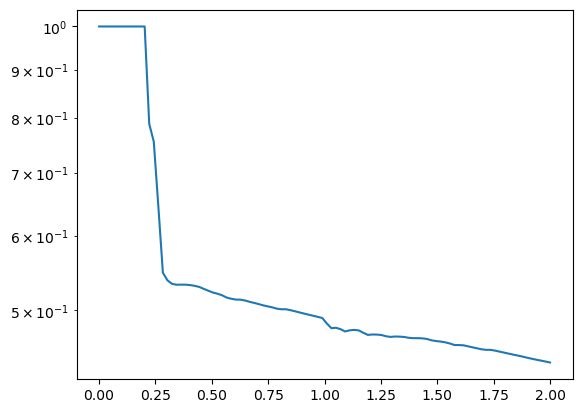

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6cff42070>

In [199]:
COSMO_time = range(0.213,stop=2,length=56)
# COSMO_time = range(1.392,stop=10,length=70)
# COSMO_time = range(10.710,stop=30,length=31)

# COSMO_time = [0.066,0.132]
# COSMO_time = range(0.544,stop=1.565,length=5)
# COSMO_time = range(4.10,stop=32.4,length=120)

COSMO_obj = COSMO_obj[1:56]
# COSMO_obj = COSMO_obj[1:70]
# COSMO_obj = COSMO_obj[1:31]

# COSMO_obj = COSMO_obj[1:2]
# COSMO_obj = COSMO_obj[1:5]
# COSMO_obj = COSMO_obj[1:120]

itp_COSMO = linear_interpolation(COSMO_time, COSMO_obj)
# f3_itp = x-> itp_COSMO(x) -r1_long[100000]
a3 = COSMO_time[1]
b3 = 2
function f3_itp(x)
    if x>= a3 && x<= b3
        return itp_COSMO(x)
    end
    if x>=0 && x<a3
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time3= range(0,stop=b3,length=100)
PyPlot.semilogy(time3, [abs(f3_itp(i)-r1_long[100000])/abs(f3_itp(0)-r1_long[100000]) for i in time3])

In [142]:
# y4 = Variable(n)
# Prob = minimize(0.5*quadform(y4,Q; assume_psd=true)+dot(c,y4)-1, norm(A*y4 - b, 2) <= 1)
# @time Convex.solve!(Prob, SCS.Optimizer)
# # z = evaluate(y3)


model = Model(SCS.Optimizer)
# set_optimizer_attribute(model, "Presolve", 0)

JuMP.@variable(model, y[1:n])
JuMP.@objective(model, Min, 0.5*y'*Q*y + c'*y - 1.0)
JuMP.@constraint(model, [1; A*y-b] in SecondOrderCone())
@time optimize!(model)

 77.525261 seconds (1.11 k allocations: 838.213 MiB, 3.95% gc time)
------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 1601, constraints m: 2403
cones: 	  q: soc vars: 2403, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 2564002, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.68e+03  3.65e+00  4.29e+03 -1.65e+03  1.00e-01  6.54e+00 
   250| 3.36e+01  1.02e-03  2.77e+00  4.24e+04  2.37e-03  

In [200]:
str4 = 
"
     0| 2.54e+02  2.99e+00  6.82e+02 -1.98e+02  1.00e-01  2.64e-01 
   250| 4.42e+01  6.73e-02  8.32e+01  6.96e+03  2.26e-03  7.74e-01 
   500| 9.78e+01  1.88e-02  1.21e+01  7.76e+03  1.38e-04  1.26e+00 
   750| 1.02e+04  1.99e-01  4.89e-01  1.14e+04  1.38e-04  1.52e+00 
  1000| 4.44e+01  8.16e-03  2.56e-01  8.05e+03  2.45e-03  1.98e+00 
  1250| 2.90e+03  1.38e+00  2.03e-01  1.89e+04  2.45e-03  2.23e+00 
  1500| 2.46e+01  4.01e-03  2.40e+00  1.31e+04  2.45e-03  2.48e+00 
"

# "
#      0| 4.41e+02  3.51e+00  1.28e+03 -3.42e+02  1.00e-01  1.59e+00 
#    250| 1.82e+19  3.18e+16  3.12e+19  9.54e+20  2.47e-03  4.78e+00 
#    500| 2.86e+02  8.64e-02  8.92e+01  1.81e+04  8.06e-05  7.91e+00 
#    750| 1.35e+02  2.32e-06  3.18e-01  1.57e+04  8.06e-05  9.14e+00 
#   1000| 1.30e+02  7.23e-03  2.08e+00  1.56e+04  1.16e-03  1.23e+01 
# "
# "
#      0| 7.55e+02  3.74e+00  2.15e+03 -2.09e+01  1.00e-01  1.23e+01 
#    250| 4.25e+19  7.20e+16  2.15e+21  2.82e+21  2.85e-03  3.70e+01
#    500| 9.30e+02  3.47e-01  3.10e+02  4.91e+04  6.18e-05  6.22e+01
# "

# "
#      0| 7.24e+02  2.96e+00  1.86e+03 -8.39e+02  1.00e-01  1.50e-01 
#    250| 3.83e+02  1.25e+00  1.67e+00  1.40e+04  2.55e-02  3.45e-01 
#    500| 9.61e+00  1.57e-03  4.52e-04  7.47e+03  7.82e-03  5.40e-01 
#    750| 8.76e+00  1.44e-03  1.28e-02  7.93e+03  7.82e-03  6.95e-01 
#   1000| 7.98e+00  1.32e-03  1.42e-02  8.31e+03  7.82e-03  8.52e-01 
#   1250| 7.26e+00  1.21e-03  2.39e-02  8.64e+03  7.82e-03  1.01e+00 
#   1500| 6.61e+00  1.11e-03  2.74e-02  8.92e+03  7.82e-03  1.17e+00 
#   1750| 6.00e+00  1.01e-03  2.36e-02  9.16e+03  7.82e-03  1.32e+00 
#   2000| 5.44e+00  9.33e-04  2.98e-02  9.36e+03  7.82e-03  1.46e+00 
#   2250| 1.13e+02  9.90e-02  1.44e+00  8.82e+03  7.82e-03  1.61e+00 
#   2500| 4.74e+00  7.85e-04  2.50e-02  9.68e+03  7.82e-03  1.75e+00 
#   2750| 4.43e+00  7.20e-04  2.30e-02  9.81e+03  7.82e-03  1.90e+00 
#   3000| 4.14e+00  6.60e-04  2.04e-02  9.92e+03  7.82e-03  2.04e+00 
#   3250| 3.87e+00  6.06e-04  1.36e-02  1.00e+04  7.82e-03  2.19e+00 
#   3500| 3.62e+00  5.56e-04  1.10e-02  1.01e+04  7.82e-03  2.34e+00 
#   3750| 3.38e+00  5.11e-04  6.02e-03  1.02e+04  7.82e-03  2.48e+00 
#   4000| 3.16e+00  4.69e-04  7.27e-03  1.02e+04  7.82e-03  2.63e+00 
#   4250| 2.96e+00  4.32e-04  1.23e-05  1.03e+04  7.82e-03  2.78e+00 
#   4500| 2.77e+00  3.96e-04  1.61e-03  1.03e+04  7.82e-03  2.92e+00 
#   4750| 2.59e+00  3.64e-04  4.37e-03  1.04e+04  7.82e-03  3.07e+00 
# "

# "
#      0| 1.14e+03  3.62e+00  3.12e+03 -1.44e+03  1.00e-01  7.65e-01 
#    250| 1.70e+01  1.37e-03  2.21e+00  1.51e+04  4.74e-03  2.26e+00 
#    500| 1.61e+01  1.32e-03  1.93e+00  1.64e+04  4.74e-03  2.90e+00 
#    750| 7.73e+03  3.42e+00  2.80e+00  6.17e+04  4.74e-03  3.53e+00 
#   1000| 1.48e+01  1.22e-03  1.55e+00  1.86e+04  4.74e-03  4.18e+00 
#   1250| 1.43e+01  1.18e-03  1.41e+00  1.97e+04  4.74e-03  4.82e+00 
#   1500| 1.39e+01  1.14e-03  1.29e+00  2.06e+04  4.74e-03  5.46e+00 
#   1750| 1.36e+01  1.11e-03  1.18e+00  2.16e+04  4.74e-03  6.09e+00 
#   2000| 1.33e+01  1.08e-03  1.09e+00  2.25e+04  4.74e-03  6.73e+00 
#   2250| 1.31e+01  1.05e-03  1.02e+00  2.34e+04  4.74e-03  7.38e+00 
#   2500| 1.28e+01  1.02e-03  9.49e-01  2.42e+04  4.74e-03  8.02e+00 
#   2750| 1.25e+01  9.91e-04  8.87e-01  2.50e+04  4.74e-03  8.66e+00 
#   3000| 1.23e+01  9.66e-04  8.31e-01  2.57e+04  4.74e-03  9.33e+00 
#   3250| 1.21e+01  9.42e-04  7.81e-01  2.65e+04  4.74e-03  9.97e+00 
#   3500| 2.95e+03  1.30e+00  2.03e+00  5.07e+04  4.74e-03  1.06e+01 
# "

# "
#      0| 1.68e+03  3.65e+00  4.29e+03 -1.65e+03  1.00e-01  6.54e+00 
#    250| 3.36e+01  1.02e-03  2.77e+00  4.24e+04  2.37e-03  1.87e+01 
#    500| 1.52e+02  2.76e-06  4.73e+01 -5.54e+02  2.37e-03  2.15e+01 
#    750| 3.68e+01  2.11e-03  2.52e+00  9.11e+04  8.54e-03  2.85e+01 
#   1000| 3.62e+01  3.00e-03  2.50e+00  9.85e+04  8.54e-03  3.13e+01 
# "
SCS_obj, SCS_time = extract_vectors(str4, 5, 7)

([-198.0, 6960.0, 7760.0, 11400.0, 8050.0, 18900.0, 13100.0], [0.264, 0.774, 1.26, 1.52, 1.98, 2.23, 2.48])

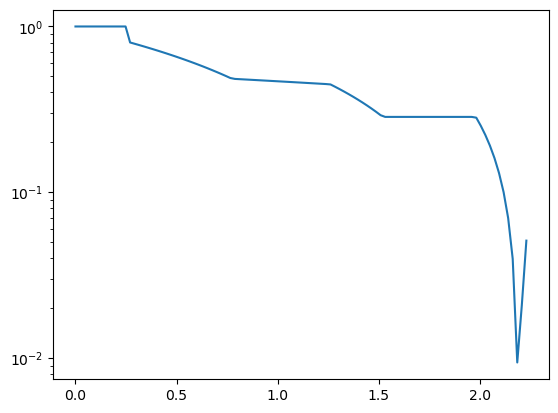

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6cd83cd30>

In [202]:
SCS_obj = SCS_obj[1:6]
# SCS_obj = [-342.0, 18100.0, 15700.0, 15600.0]
# SCS_obj = [-20.9, 49100.0]

# SCS_obj = SCS_obj[1:20]
# SCS_obj = SCS_obj[1:15]
# SCS_obj = SCS_obj[1:5]

SCS_obj = cleanData2(SCS_obj)


SCS_time = SCS_time[1:6]
# SCS_time = [1.59, 7.91, 9.14, 12.3]
# SCS_time = [12.3, 62.2]

# SCS_time = SCS_time[1:20]
# SCS_time = SCS_time[1:15]
# SCS_time = SCS_time[1:5]


itp_SCS = linear_interpolation(SCS_time, SCS_obj)
# f4_itp = x-> itp_SCS(x) -r1_long[100000]
a4 = SCS_time[1]
b4 = SCS_time[6]
function f4_itp(x)
    if x>= a4 && x<= b4
        return itp_SCS(x)
    end
    if x>=0 && x<a4
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time4= range(0,stop=b4,length=100)
PyPlot.semilogy(time4, [abs(f4_itp(i)-r1_long[100000])/abs(f4_itp(0)-r1_long[100000]) for i in time4])

In [250]:
f4_itp(10)

9.539999999999999e20

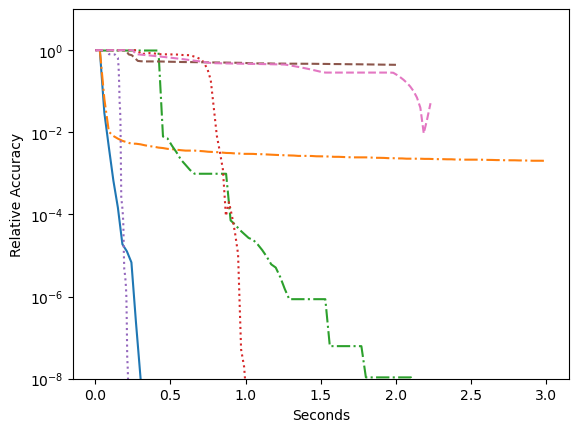

In [204]:
experiment_time = 3
sample = 100
f0 = obj_grad(x0)[1] + 0.5*e'*Q*e.+dot(c,e)

ep1, step1 = radial_accelerate(rad_obj_grad1, rad_obj_grad3 , x0, 110, 0.0012, experiment_time, sample)
ep1 = ep1 .+ 0.5*e'*Q*e.+dot(c,e)
ep2, step2 = sw_subgrad(sw_obj_grad1,x0,0.025,0.0077,experiment_time,sample)
ep2 = ep2 .+ 0.5*e'*Q*e.+dot(c,e)
ep3, step3 = agd(lagrange_obj_grad1,x0,220000,24,experiment_time,sample)
ep3 = ep3 .+ 0.5*e'*Q*e.+dot(c,e)

ep1 = cleanData(ep1)
ep2 = cleanData(ep2)
ep3 = cleanData(ep3)



PyPlot.semilogy((experiment_time/sample).*(1:sample), (ep1.-r1_long[100000])/(f0-r1_long[100000]), label = "Radial_GenGrad_Accel", linestyle = "solid")
PyPlot.semilogy((experiment_time/sample).*(1:sample), (ep2.-r1_long[100000])/(f0-r1_long[100000]), label = "Switching_Subgrad", linestyle = "dashdot")
PyPlot.semilogy((experiment_time/sample).*(1:sample), (ep3.-r1_long[100000])/(f0-r1_long[100000]), label = "Ideal_Lagrange_Accel", linestyle = "dashdot")
PyPlot.semilogy(time1, [abs(f1_itp(i)-r1_long[100000])/(f0-r1_long[100000]) for i in time1], label = "Gurobi", linestyle = "dotted")
PyPlot.semilogy(time2, [abs(f2_itp(i)-r1_long[100000])/(f0-r1_long[100000]) for i in time2], label = "Mosek", linestyle = "dotted")
PyPlot.semilogy(time3, [abs(f3_itp(i)-r1_long[100000])/(f0-r1_long[100000]) for i in time3], label = "COSMO", linestyle = "dashed")
PyPlot.semilogy(time4, [abs(f4_itp(i)-r1_long[100000])/(f0-r1_long[100000]) for i in time4], label = "SCS", linestyle = "dashed")


# legend()
# legend(bbox_to_anchor=(1.0,1.0))

ylim(1e-8,1e1)
xlabel("Seconds")
ylabel("Relative Accuracy")
savefig("up_cellips_solver_400")
# savefig("up_cellips_solver_1600", bbox_inches="tight")

### p = 4-norm Ellipsoid Constrained Optimization

We implement our radial methods on three different data dimensions (400,200), (800,400), (1600,800), comparing with solvers Mosek, COSMO, SOS.

The following table gives tuned parameters $L$ and $\mu$ of accelerated methods.

| Dimension (n,m) | (400, 200) | (800,400) | (1600,800) |
| --- | --- | --- | --- |
| Radial Accelerate  |  (7.6,1.2e-3) | (13, 8.6e-4) | (6.7,3.7e-4) |
| Switching Subgradient | (0.016,0.019) | (0.000027,0.013) | (0.000052,0.0065) |
| Ideal Lagragian Accelerate | (180000,19) | (670000,58) | (2200000,130) |

In [109]:
n = 400
m = 200

x0 = zeros(n)
Random.seed!(123)
P = randn(n,n)
Q = P'*P
c = randn(n)



A = randn(m, n)
b = A*randn(n) + 1/m*randn(m)



e = conjugate_gradient(A'*A, A'*b, x0, 30)
b_e = b-A*e
c_e = c+Q*e




function rad_obj_grad4(x)
    Ax = A*x
    
    w = [0.0,0.0,0.0,0.0,-1.0]
    for i in 1:m
        w[1] += Ax[i]^4 
        w[2] += -4*Ax[i]^3*b_e[i]
        w[3] += 6*Ax[i]^2*b_e[i]^2
        w[4] += -4*Ax[i]*b_e[i]^3
        w[5] += b_e[i]^4
    end
    sol = roots(Polynomial(w))
    
    i_best=1
    val_best = abs(imag(sol[1])) + min(0, -1*real(sol[1]))
    for i in 2:4
        cur = abs(imag(sol[i])) + min(0, -1*real(sol[i]))
        if cur < val_best
            i_best = i
            val_best = cur
        end
    end
    f = real(sol[i_best])
    
    v = (Ax/f-b_e).^3
    zeta = A'*v
    gradf = zeta/dot(zeta, x/f)
    
    if norm(x,2)<=1e-12
        return 0.5*f^2, zeros(n)
    else
        return 0.5*f^2, f*gradf
    end
end

AA = A'*A
Ab_e = A'*b_e
nb = 1-norm(b_e,2)^2
function sw_obj_grad2(x)
    Px = P*x
    cx = dot(c_e,x)
    Ax = A*x
    f1 = 0.5*norm(Px,2)^2+cx-1
    gradf1 = P'*(Px)+c_e
    f2 = norm(Ax-b_e,4)^2-1
    gradf2 = 4*A'*(Ax-b_e).^3/(2*(f2+1))
    return f1, f2, gradf1, gradf2
end


function lagrange_obj_grad2(x)
    Px = P*x
    cx = dot(c_e,x)
    Ax = A*x
    
    f1 = 0.5*norm(Px,2)^2+cx-1
    f2 = norm(Ax-b_e,4)^2-1
    gradf = P'*(Px)+c_e+4*lambda*A'*(Ax-b_e).^3/(2*(f2+1))
    return f1, f2, gradf
end


lagrange_obj_grad2 (generic function with 1 method)

In [110]:
opt_x2,qt_long1, step_long1 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 7.6, 0.0012, 100000)
qt_long1 = qt_long1.+ 0.5*e'*Q*e.+dot(c,e)
qt_long1 = cleanData(qt_long1)
# opt_x2,qt_long2, step_long2 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 13, 0.00086, 100000)
# qt_long2 = qt_long2.+ 0.5*e'*Q*e.+dot(c,e)
# qt_long2 = cleanData(qt_long2)
# opt_x2,qt_long3, step_long3 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 6.7, 0.00037, 100000)
# qt_long3 = qt_long3.+ 0.5*e'*Q*e.+dot(c,e)
# qt_long3 = cleanData(qt_long3)


100000-element Vector{Float64}:
 40073.40314281781
 40071.12269267954
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
 39911.880958454494
     ⋮
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834
 17187.777352180834

In [111]:
_,_, grad3, grad4=sw_obj_grad2(opt_x2)
opt_lambda = norm(grad3,2)/norm(grad4,2)
lambda = opt_lambda

406.4090439339693

In [26]:
# y1 = Variable(n)
# Prob = minimize(0.5*quadform(y1,Q; assume_psd=true)+dot(c,y1)-1, norm(A*y1 - b, 4) <= 1)
# @time Convex.solve!(Prob, Gurobi.Optimizer)
# z = evaluate(y1)
# Prob.optval



# set_optimizer_attribute(model, "Presolve", 0)

# model = Model(Gurobi.Optimizer)

# JuMP.@variable(model, y[1:n])
# JuMP.@variable(model, r[1:m])
# JuMP.@constraint(model, [i=1:m], [r[i], 1, (A*y-b)] in MOI.PowerCone(1 / 4))
# JuMP.@constraint(model, sum(r) == 1)
# JuMP.@objective(model, Min, 0.5*y'*Q*y + dot(c,y)-1)
# optimize!(model)



Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-19
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 12008 rows, 13608 columns and 5145612 nonzeros
Model fingerprint: 0xb4434c58
Model has 1602 quadratic constraints
Coefficient statistics:
  Matrix range     [2e-07, 4e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-03, 1e+02]
Presolve removed 4003 rows and 3201 columns (presolve time = 11s) ...
Presolve removed 4003 rows and 3201 columns
Presolve time: 11.23s
Presolved: 8005 rows, 10407 columns, 5136809 nonzeros
Presolved model has 1602 second-order cone constraints
Ordering time: 0.36s

Barrier statistics:
 Free vars  : 2400
 AA' NZ     : 1.025e+07
 Factor NZ  : 1.297e+07 (roughly 110 MB of memory)
 Facto

┌ Warning: Problem status LOCALLY_SOLVED; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


-20.531281606018243

In [563]:
radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 6.7, 0.00037, 20, 100)

([-1.0, -128.99751276028675, -1000.5620909731566, -7384.583655339358, -24458.089088342727, -34807.16890273771, -42600.44653551577, -52571.60555938606, -61817.87082344047, -68627.38756037063  …  -313515.62125174905, -313515.62125174905, -313515.6212462927, -313515.621251681, -313515.6212410858, -313515.62125174905, -313515.6212462927, -313515.621251684, -313515.62125174905, -313515.62125174777], 3120)

In [128]:
str1 = 
"
   0   5.47504951e+01 -1.52600000e+00  2.24e+04 2.98e+00  5.70e+00     1
   1  -1.02364055e+02 -4.18143324e-01  2.19e+04 2.89e+00  5.55e+00     1
   2  -2.00650651e+02  1.50264420e+00  2.11e+04 2.68e+00  5.27e+00     1
   3  -9.99604701e+01  2.58876419e+00  1.95e+04 2.54e+00  4.97e+00     1
   4  -2.74522783e+02  1.28483898e+01  1.76e+04 1.74e+00  4.07e+00     1
   5  -3.12102679e+02  1.59246776e+01  1.11e+04 7.03e-01  2.15e+00     1
   6  -2.08786866e+02  5.25905190e+01  6.20e+03 1.78e-04  1.77e+00     1
   7  -1.05079760e+02  1.19361416e+02  3.64e+03 4.29e-05  1.05e+00     1
   8  -4.26053418e+01  2.17909194e+02  2.51e+03 3.47e-05  7.20e-01     1
   9  -9.88153110e+00  3.41350476e+02  2.09e+03 2.99e-05  6.16e-01     1
  10   6.57952947e+00  4.56535796e+02  1.96e+03 2.67e-05  6.22e-01     1
  11   4.73151482e+01  6.52557952e+02  1.69e+03 2.54e-05  5.60e-01     1
  12   1.72175452e+02  8.21068675e+02  1.45e+03 2.36e-05  5.84e-01     1
  13   2.74980906e+02  1.29105160e+03  1.20e+03 2.04e-05  4.69e-01     1
  14   3.58488611e+02  1.71777818e+03  1.07e+03 1.73e-05  3.84e-01     1
  15   6.40711903e+02  2.27266003e+03  8.87e+02 1.67e-05  3.04e-01     1
  16   7.67149883e+02  3.03192429e+03  8.27e+02 1.53e-05  2.54e-01     1
  17   1.00395320e+03  2.55747568e+03  7.51e+02 1.50e-05  4.17e-01     1
  18   1.14573132e+03  3.35546862e+03  7.16e+02 1.42e-05  3.81e-01     1
  19   1.73268911e+03  4.87489543e+03  6.13e+02 1.34e-05  4.21e-01     1
  20   2.40544985e+03  6.04263841e+03  5.10e+02 1.18e-05  6.01e-01     1
  21   2.70726481e+03  7.07256392e+03  4.75e+02 1.07e-05  8.82e-01     1
  22   3.03895985e+03  7.84582028e+03  4.43e+02 1.02e-05  9.23e-01     2
  23   3.69785001e+03  9.41420100e+03  3.88e+02 9.27e-06  1.20e+00     2
  24   4.34896712e+03  1.05781426e+04  3.45e+02 8.08e-06  1.57e+00     2
  25   5.01445166e+03  1.10171202e+04  3.07e+02 7.05e-06  2.17e+00     2
  26   5.60826644e+03  1.24559309e+04  2.80e+02 6.06e-06  2.98e+00     2
  27   7.80163247e+03  1.34155044e+04  2.19e+02 4.53e-06  5.54e+00     2
  28   9.50871666e+03  1.43877496e+04  1.67e+02 3.94e-06  6.70e+00     2
  29   1.08637024e+04  1.55029015e+04  1.28e+02 2.67e-06  5.68e+00     2
  30   1.32610805e+04  1.61418519e+04  7.64e+01 2.73e-06  4.27e+00     2
  31   1.41340039e+04  1.64879701e+04  5.51e+01 1.28e-06  3.14e+00     2
  32   1.54972295e+04  1.67332167e+04  2.63e+01 8.62e-07  1.63e+00     2
  33   1.62743006e+04  1.69089595e+04  1.20e+01 6.21e-07  8.56e-01     2
  34   1.68072194e+04  1.70756141e+04  4.22e+00 3.98e-07  3.84e-01     2
  35   1.70796150e+04  1.71546291e+04  1.16e+00 2.38e-07  1.41e-01     2
  36   1.71536118e+04  1.71779745e+04  2.51e-01 2.12e-07  3.55e-02     2
  37   1.71643379e+04  1.71848652e+04  6.14e-02 1.33e-06  9.02e-03     2
  38   1.72134715e+04  1.71874579e+04  7.65e-03 1.36e-06  1.45e-03     2
  39   1.71882097e+04  1.71877592e+04  2.16e-04 5.73e-05  4.50e-05     2
  40   1.71878628e+04  1.71877772e+04  4.34e-05 4.08e-05  3.29e-06     2
  41   1.71877786e+04  1.71877772e+04  9.76e-06 1.49e-05  2.28e-07     2
"
# "
#    0   1.07303070e+02 -1.52600000e+00  8.68e+04 3.50e+00  1.10e+01     3.67
#    1  -2.19359458e+02 -2.67952220e+00  8.50e+04 3.39e+00  1.07e+01     4
#    2  -4.22068952e+02 -4.16597397e+00  8.21e+04 3.16e+00  1.02e+01     4.33
#    3  -2.64912951e+02 -2.31224671e+00  7.44e+04 3.00e+00  9.45e+00     4.67
#    4  -5.96343633e+02 -1.03860236e+00  6.55e+04 1.65e+00  7.02e+00     5
#    5  -6.05376850e+02  1.51971914e+01  4.33e+04 6.16e-01  3.78e+00     5.25
#    6  -4.01764059e+02  7.58805755e+01  2.26e+04 4.07e-04  3.32e+00     5.50
#    7  -1.55476673e+02  2.06708917e+02  1.14e+04 6.68e-05  1.66e+00     5.75
#    8  -8.16936361e+01  3.79523039e+02  8.60e+03 5.35e-05  1.26e+00     6
#    9  -1.99647005e+01  5.93657773e+02  6.95e+03 4.71e-05  1.02e+00     6.33
#   10   7.11093142e+01  1.00594003e+03  5.74e+03 4.25e-05  8.77e-01     6.67
#   11   3.09652359e+02  2.24384574e+03  4.91e+03 3.48e-05  1.09e+00     7
#   12   6.33168891e+02  3.49112577e+03  3.79e+03 3.07e-05  7.71e-01     7.33
#   13   1.22940101e+03  5.75486603e+03  3.13e+03 2.81e-05  7.59e-01     7.67
#   14   1.64084891e+03  7.61521473e+03  2.83e+03 2.55e-05  8.23e-01     8
#   15   2.71152714e+03  9.58996316e+03  2.49e+03 2.40e-05  1.05e+00     8.33
#   16   3.68976304e+03  1.14504068e+04  2.15e+03 2.09e-05  9.53e-01     8.67
#   17   4.51435378e+03  1.62491037e+04  1.92e+03 1.91e-05  9.55e-01     9
#   18   6.48521481e+03  1.66381534e+04  1.68e+03 1.71e-05  1.48e+00     9.25
#   19   9.08130932e+03  2.46985796e+04  1.44e+03 1.45e-05  2.69e+00     9.5
#   20   1.07220787e+04  3.17400714e+04  1.29e+03 1.20e-05  3.15e+00     9.75
#   21   1.41156525e+04  3.60033494e+04  1.08e+03 9.63e-06  3.93e+00    10
#   22   1.73406390e+04  3.91329836e+04  9.13e+02 1.05e-05  3.61e+00    10.25
#   23   2.00738958e+04  4.46218889e+04  8.06e+02 7.03e-06  4.64e+00    10.5
#   24   2.47536165e+04  4.93741579e+04  6.52e+02 5.67e-06  4.84e+00    10.75
#   25   2.76426779e+04  5.24534804e+04  5.69e+02 4.80e-06  4.82e+00    11
#   26   3.39228530e+04  5.67149573e+04  4.20e+02 3.55e-06  4.82e+00    11.33
#   27   4.05924117e+04  6.08021147e+04  3.06e+02 2.74e-06  4.92e+00    11.67
#   28   6.32705513e+04  6.62008376e+04  1.93e+02 2.64e-06  3.56e+00    12
#   29   6.41948871e+04  6.69655597e+04  1.43e+02 1.45e-06  2.56e+00    12.33
#   30   6.61533063e+04  6.76811738e+04  7.55e+01 1.44e-06  2.02e+00    12.67
#   31   7.19146447e+04  6.79496910e+04  5.51e+01 1.86e-06  1.21e+00    13
#   32   6.94947232e+04  6.85443227e+04  1.79e+01 1.39e-05  5.39e-01    13.33
#   33   6.91022409e+04  6.89613102e+04  6.59e+00 2.32e-05  4.48e-01    13.67
#   34   6.93019019e+04  6.93341157e+04  1.33e+00 8.51e-05  4.89e-01    14
#   35   6.90792453e+04  6.94103567e+04  6.41e-02 1.12e-03  1.82e-02    14.33
#   36   6.94072527e+04  6.94155622e+04  2.10e-03 5.67e-05  2.78e-03    14.67
#   37   6.94160773e+04  6.94167439e+04  2.16e-04 5.59e-05  4.41e-04    15
#   38   6.94171710e+04  6.94170555e+04  3.12e-07 1.65e-04  9.61e-05    15.5
#   39   6.94171333e+04  6.94170664e+04  3.25e-05 3.25e-04  5.97e-05    16
#   40   6.94171316e+04  6.94170664e+04  9.11e-04 6.66e-04  5.97e-05    16.5
#   41   6.94171316e+04  6.94170664e+04  7.02e-05 1.09e-03  5.97e-05    17
#   42   6.94171316e+04  6.94170665e+04  4.67e-04 1.25e-03  5.96e-05    17.5
#   43   6.94171316e+04  6.94170665e+04  1.00e-03 1.32e-03  5.96e-05    18
#   44   6.94171315e+04  6.94170666e+04  2.09e-03 1.34e-03  5.95e-05    18.5
#   45   6.94171589e+04  6.94170833e+04  9.65e-07 1.14e-03  6.29e-05    19
#   46   6.94171568e+04  6.94170834e+04  6.52e-04 2.37e-03  6.19e-05    19.5
#   47   6.94171531e+04  6.94170835e+04  5.71e-04 4.90e-03  6.01e-05    20
#   48   6.94171503e+04  6.94170837e+04  5.04e-04 1.01e-02  5.86e-05    20.5
#   49   6.94171332e+04  6.94170875e+04  3.83e-04 1.66e-03  4.48e-05    21
#   50   6.94171314e+04  6.94170875e+04  1.28e-04 1.25e-04  4.43e-05    21.5
#   51   6.94171297e+04  6.94170875e+04  1.13e-04 2.59e-04  4.39e-05    22
#   52   6.94171297e+04  6.94170875e+04  6.41e-04 1.37e-04  4.39e-05    22.5
#   53   6.94171297e+04  6.94170875e+04  1.33e-03 4.82e-04  4.40e-05    23
#   54   6.94171297e+04  6.94170875e+04  2.76e-03 1.23e-03  4.40e-05    23.5
#   55   6.94171296e+04  6.94170875e+04  2.46e-04 3.48e-03  4.40e-05    23
#   56   6.94171296e+04  6.94170876e+04  2.85e-04 8.93e-03  4.40e-05    24
#   57   6.94171296e+04  6.94170876e+04  2.48e-04 3.22e-02  4.39e-05    24.5
#   58   6.94171296e+04  6.94170877e+04  2.82e-04 8.14e-02  4.38e-05    25
#   59   6.94171296e+04  6.94170881e+04  2.51e-04 2.06e-01  4.35e-05    25.5

# "
# "
#    0   1.52445716e+02 -1.50725000e+00  2.46e+05 7.47e+00  1.56e+01    20
#    1  -4.09221782e+02 -1.60501311e+00  2.44e+05 7.41e+00  1.55e+01    23
#    2  -7.60325884e+02  3.13157063e+00  2.36e+05 6.74e+00  1.49e+01    25
#    3  -1.04107871e+03  1.43632591e+01  1.15e+05 3.69e+00  7.88e+00    27
#    4  -5.58608813e+02  3.91994944e+01  6.64e+04 8.91e-01  3.52e+00    30
#  "
Gurobi_obj, Gurobi_time = extract_vectors(str1,2,7)

([54.7504951, -102.364055, -200.650651, -99.9604701, -274.522783, -312.102679, -208.786866, -105.07976, -42.6053418, -9.8815311  …  15497.2295, 16274.3006, 16807.2194, 17079.615, 17153.6118, 17164.3379, 17213.4715, 17188.2097, 17187.8628, 17187.7786], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])

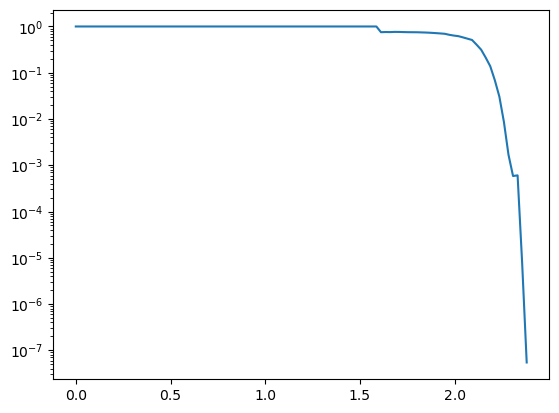

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6f6212100>

In [129]:
using Interpolations
Gurobi_time = 1.601:0.019:2.38
# Gurobi_time = Gurobi_time[1:38]
# Gurobi_time = Gurobi_time[1:5]

Gurobi_obj = Gurobi_obj[1:42]
# Gurobi_obj = Gurobi_obj[1:38]
# Gurobi_obj = Gurobi_obj[1:5]


itp_Gurobi = linear_interpolation(Gurobi_time, Gurobi_obj)

a1 = Gurobi_time[1]
b1 = 2.38
function f11_itp(x)
    if x>= a1 && x<= b1
        return itp_Gurobi(x)
    end
    if x>=0 && x<a1
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time1= range(0,stop=b1,length=100)
PyPlot.semilogy(time1, [abs(f11_itp(i)-qt_long1[100000])/abs(f11_itp(0)-qt_long1[100000]) for i in time1])

In [24]:
y2 = Variable(n)
Prob = minimize(0.5*quadform(y2,Q; assume_psd=true)+dot(c,y2)-1, norm(A*y2 - b, 4) <= 1)
@time Convex.solve!(Prob, Mosek.Optimizer)
# z = evaluate(y2)

# model = Model(Mosek.Optimizer)

# JuMP.@variable(model, y[1:n])
# JuMP.@variable(model, r[1:m])
# JuMP.@constraint(model, [i=1:m], [r[i], 1, (A[i,:]'*y-b[i])] in MOI.PowerCone(1 / 4))
# JuMP.@constraint(model, sum(r) == 1)
# JuMP.@objective(model, Min, 0.5*y'*Q*y + dot(c,y)-1)
# @time optimize!(model)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 5604            
  Affine conic cons.     : 1602            
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 7204            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 3200
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.03            
Lin. dep.  - number                 : 0               
Presolve te

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


In [130]:
str2 = 
"
0   1.2e+01  3.0e+00  1.5e+00  0.00e+00   -1.000000000e+00  -1.500000000e+00  1.0e+00  0.39  
1   4.6e+00  1.1e+00  9.0e-01  -9.98e-01  -4.481385830e-01  7.107982926e-01   3.7e-01  0.43  
2   3.3e+00  7.9e-01  7.4e-01  -9.50e-01  4.430216368e-01   2.449254415e+00   2.7e-01  0.45  
3   5.6e-01  1.3e-01  2.9e-01  -9.70e-01  4.369422456e+01   6.072729428e+01   4.5e-02  0.48  
4   1.5e-01  3.6e-02  1.4e-01  -9.07e-01  4.643542528e+02   5.206136435e+02   1.2e-02  0.51  
5   7.4e-02  1.8e-02  8.4e-02  -6.33e-01  1.764145347e+03   1.851032679e+03   5.9e-03  0.53  
6   5.2e-02  1.2e-02  4.1e-02  1.64e-01   5.545987627e+03   5.587668036e+03   4.2e-03  0.55  
7   2.9e-02  7.0e-03  2.8e-02  -2.37e-01  7.048312508e+03   7.111257774e+03   2.4e-03  0.57  
8   1.2e-02  2.9e-03  2.5e-03  1.28e+00   1.452301619e+04   1.452561658e+04   9.9e-04  0.59  
9   2.2e-03  5.3e-04  1.3e-04  1.31e+00   1.678461557e+04   1.678482833e+04   1.8e-04  0.60  
10  2.6e-04  6.3e-05  1.2e-05  1.38e+00   1.713087047e+04   1.713101103e+04   2.1e-05  0.63  
11  4.6e-05  1.1e-05  8.5e-07  1.03e+00   1.718026251e+04   1.718028529e+04   3.7e-06  0.65  
12  1.0e-05  2.4e-06  8.6e-08  1.05e+00   1.718589218e+04   1.718589697e+04   8.2e-07  0.71  
13  4.3e-06  5.4e-07  9.4e-09  8.99e-01   1.718724914e+04   1.718725033e+04   1.8e-07  0.72  
14  6.3e-07  1.5e-07  1.7e-09  9.35e-01   1.718762246e+04   1.718762280e+04   5.0e-08  0.74  
15  3.0e-07  1.1e-07  6.7e-10  9.73e-01   1.718770382e+04   1.718770398e+04   2.4e-08  0.78  
16  8.3e-08  1.7e-07  1.5e-10  9.73e-01   1.718775725e+04   1.718775730e+04   6.4e-09  0.81  
17  1.2e-08  2.4e-07  2.9e-11  9.87e-01   1.718777436e+04   1.718777437e+04   9.4e-10  0.84  
18  1.9e-09  7.0e-07  7.2e-12  9.95e-01   1.718777689e+04   1.718777689e+04   1.5e-10  0.88  
19  1.9e-09  7.1e-07  2.8e-12  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  0.93  
20  1.9e-09  7.1e-07  2.8e-12  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  0.98  
21  1.9e-09  7.1e-07  4.3e-14  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  1.04  
22  1.9e-09  7.1e-07  4.3e-14  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  1.11  
23  1.9e-09  7.1e-07  4.3e-14  9.98e-01   1.718777689e+04   1.718777689e+04   1.5e-10  1.19  
24  1.5e-09  1.1e-06  1.1e-12  9.98e-01   1.718777699e+04   1.718777699e+04   1.2e-10  1.24  
25  1.5e-09  1.1e-06  1.1e-12  9.98e-01   1.718777699e+04   1.718777699e+04   1.2e-10  1.31  
26  1.5e-09  1.1e-06  1.1e-12  9.98e-01   1.718777699e+04   1.718777699e+04   1.2e-10  1.35  
"
# "
# 0   2.4e+01  3.5e+00  1.5e+00  0.00e+00   -1.000000000e+00  -1.500000000e+00  1.0e+00  2.62  
# 1   9.3e+00  1.4e+00  9.3e-01  -1.00e+00  -5.325073277e-01  5.566631159e-01   3.9e-01  2.74  
# 2   6.0e+00  8.7e-01  7.4e-01  -9.96e-01  -2.355416232e-01  2.204917532e+00   2.5e-01  2.82  
# 3   1.1e+00  1.6e-01  3.1e-01  -9.73e-01  3.594444117e+01   5.528007930e+01   4.6e-02  2.96  
# 4   4.1e-01  5.9e-02  1.8e-01  -9.49e-01  2.190658251e+02   2.707265641e+02   1.7e-02  3.04  
# 5   2.4e-01  3.5e-02  1.4e-01  -8.54e-01  4.443723111e+02   5.319341788e+02   9.9e-03  3.11  
# 6   1.8e-01  2.7e-02  1.1e-01  -7.70e-01  2.429504039e+03   2.518203737e+03   7.6e-03  3.19  
# 7   5.7e-02  8.2e-03  4.7e-02  -6.81e-01  1.148673014e+04   1.166580632e+04   2.4e-03  3.27  
# 8   2.9e-02  4.3e-03  1.6e-02  1.36e-01   3.442341543e+04   3.449583728e+04   1.2e-03  3.36  
# 9   9.2e-03  1.3e-03  1.5e-03  1.59e-01   6.041742944e+04   6.042376108e+04   3.8e-04  3.44  
# 10  1.6e-03  2.4e-04  1.2e-04  1.39e+00   6.829399127e+04   6.829538710e+04   6.8e-05  3.53  
# 11  2.1e-04  3.1e-05  7.4e-06  1.15e+00   6.922231291e+04   6.922262647e+04   8.7e-06  3.62  
# 12  3.7e-05  5.4e-06  4.9e-07  1.07e+00   6.938785211e+04   6.938789664e+04   1.6e-06  3.72  
# 13  3.6e-06  1.9e-07  1.1e-09  1.06e+00   6.941578214e+04   6.941578310e+04   5.3e-08  3.83  
# 14  2.5e-06  1.3e-07  7.8e-10  9.74e-01   6.941622208e+04   6.941622278e+04   3.6e-08  3.99  
# 15  7.4e-07  1.7e-07  1.8e-10  9.43e-01   6.941694482e+04   6.941694499e+04   7.7e-09  4.12  
# 16  7.4e-07  1.7e-07  1.8e-10  9.43e-01   6.941694482e+04   6.941694499e+04   7.7e-09  4.26  
# 17  7.4e-07  1.7e-07  1.5e-10  9.85e-01   6.941694513e+04   6.941694530e+04   7.7e-09  4.40  
# 18  7.4e-07  1.7e-07  1.0e-10  9.95e-01   6.941694513e+04   6.941694530e+04   7.7e-09  4.54  
# 19  7.0e-07  1.6e-07  7.5e-12  9.80e-01   6.941695492e+04   6.941695508e+04   7.3e-09  4.67  
# 20  7.0e-07  1.6e-07  7.5e-12  9.80e-01   6.941695492e+04   6.941695508e+04   7.3e-09  4.80  
# 21  7.0e-07  1.6e-07  7.5e-12  9.80e-01   6.941695492e+04   6.941695508e+04   7.3e-09  4.97  
# "
# "
# 0   3.4e+01  3.7e+00  1.5e+00  0.00e+00   -1.000000000e+00  -1.500000000e+00  1.0e+00  18.37 
# 1   1.3e+01  1.4e+00  9.3e-01  -1.00e+00  -5.297954908e-01  5.606732233e-01   3.9e-01  18.76 
# 2   8.3e+00  9.1e-01  7.3e-01  -9.99e-01  -1.933988809e-02  2.522858028e+00   2.4e-01  19.15 
# 3   3.2e+00  3.5e-01  4.5e-01  -9.86e-01  6.277380244e+00   1.520668442e+01   9.3e-02  19.54 
# 4   1.0e+00  1.1e-01  2.6e-01  -9.86e-01  6.522135319e+01   9.531194794e+01   3.0e-02  19.95 
# 5   4.8e-01  5.3e-02  1.7e-01  -9.62e-01  1.931276917e+02   2.594392285e+02   1.4e-02  20.34 
# 6   3.8e-01  4.2e-02  1.5e-01  -9.32e-01  1.096593072e+03   1.174982482e+03   1.1e-02  20.69 
# 7   1.1e-01  1.2e-02  7.5e-02  -9.02e-01  6.100383903e+03   6.338293069e+03   3.2e-03  21.08 
# 8   4.9e-02  5.4e-03  4.4e-02  -7.29e-01  2.555150214e+04   2.597561930e+04   1.4e-03  21.44 
# 9   3.7e-02  4.0e-03  2.2e-02  2.61e-01   9.182451284e+04   9.200601770e+04   1.1e-03  21.80 
# 10  2.0e-02  2.2e-03  1.5e-02  -3.05e-01  1.191722975e+05   1.194601197e+05   5.9e-04  22.15 
# 11  8.6e-03  9.4e-04  1.5e-03  1.52e+00   2.479573411e+05   2.479721397e+05   2.5e-04  22.51 
# 12  1.7e-03  1.9e-04  1.1e-04  1.29e+00   2.833670325e+05   2.833691110e+05   5.1e-05  22.87 
# 13  1.6e-04  1.7e-05  2.5e-06  1.43e+00   2.903727840e+05   2.903729041e+05   4.7e-06  23.44 
# 14  2.2e-05  2.4e-06  2.8e-07  1.06e+00   2.910952343e+05   2.910953153e+05   6.4e-07  23.86 
# 15  8.3e-06  9.1e-07  5.3e-08  1.06e+00   2.911714653e+05   2.911714955e+05   2.4e-07  24.47 
# 16  1.7e-06  1.9e-07  1.4e-08  5.66e-01   2.911945547e+05   2.911945661e+05   5.6e-08  25.04 
# 17  6.2e-07  1.7e-07  7.0e-09  6.35e-01   2.912047137e+05   2.912047191e+05   1.9e-08  25.58 
# 18  5.6e-07  2.0e-07  4.0e-09  6.62e-01   2.912058882e+05   2.912058930e+05   1.6e-08  26.16 
# 19  5.6e-07  2.0e-07  4.0e-09  6.62e-01   2.912058882e+05   2.912058930e+05   1.6e-08  26.83 
# 20  3.7e-07  2.3e-07  9.9e-10  7.29e-01   2.912084216e+05   2.912084250e+05   1.1e-08  27.38 
# 21  1.4e-07  4.6e-07  2.6e-10  7.71e-01   2.912123996e+05   2.912124009e+05   3.4e-09  27.94 
# 22  1.2e-07  5.5e-07  8.0e-11  8.67e-01   2.912127563e+05   2.912127574e+05   2.9e-09  28.50 
# 23  1.2e-07  5.5e-07  8.0e-11  8.67e-01   2.912127563e+05   2.912127574e+05   2.9e-09  29.16 
# 24  1.2e-07  5.5e-07  3.7e-11  8.63e-01   2.912127565e+05   2.912127576e+05   2.9e-09  29.78 
# 25  1.2e-07  5.5e-07  3.7e-11  8.63e-01   2.912127565e+05   2.912127576e+05   2.9e-09  30.43 
# 26  1.2e-07  5.5e-07  3.7e-11  8.63e-01   2.912127565e+05   2.912127576e+05   2.9e-09  31.15 
# "

# "
# 0   2.2e+02  3.0e+00  2.7e+02  0.00e+00   -2.928932188e-01  -2.662822379e+02  1.0e+00  0.14  
# 1   8.3e+01  1.1e+00  1.6e+02  -9.70e-01  4.562753232e+00   -2.561338573e+02  3.7e-01  0.16  
# 2   3.7e+01  4.9e-01  1.0e+02  -9.52e-01  3.737221093e+01   -2.134090039e+02  1.6e-01  0.17  
# 3   1.7e+01  2.2e-01  6.6e+01  -9.04e-01  2.027019174e+02   -2.836012061e+01  7.4e-02  0.18  
# 4   7.4e+00  9.9e-02  3.9e+01  -7.93e-01  9.265165588e+02   7.325645193e+02   3.3e-02  0.19  
# 5   3.1e+00  4.1e-02  1.8e+01  -5.44e-01  3.584919586e+03   3.452464533e+03   1.4e-02  0.20  
# 6   8.9e-01  1.2e-02  4.0e+00  -3.16e-02  1.048535990e+04   1.043269977e+04   4.0e-03  0.21  
# 7   1.3e-01  1.8e-03  2.7e-01  6.57e-01   1.583432118e+04   1.582528180e+04   6.0e-04  0.22  
# 8   2.2e-02  3.0e-04  2.3e-02  7.75e-01   1.681773373e+04   1.681616266e+04   1.0e-04  0.23  
# 9   7.9e-03  1.1e-04  5.9e-03  6.33e-01   1.701989338e+04   1.701929328e+04   3.5e-05  0.24  
# 10  3.6e-03  4.9e-05  1.9e-03  7.98e-01   1.710498224e+04   1.710468990e+04   1.6e-05  0.25  
# 11  3.7e-04  5.0e-06  6.5e-05  8.94e-01   1.717760636e+04   1.717757617e+04   1.7e-06  0.26  
# 12  4.0e-05  5.3e-07  2.3e-06  1.00e+00   1.718669579e+04   1.718669259e+04   1.8e-07  0.28  
# 13  1.8e-06  2.4e-08  2.3e-08  1.00e+00   1.718773108e+04   1.718773093e+04   8.4e-09  0.29  
# 14  7.6e-08  5.8e-08  1.8e-10  1.00e+00   1.718777556e+04   1.718777555e+04   3.5e-10  0.31  
# 15  5.4e-09  5.5e-07  4.1e-12  1.00e+00   1.718777722e+04   1.718777722e+04   2.5e-11  0.32  
# 16  5.4e-09  5.5e-07  4.1e-12  1.00e+00   1.718777722e+04   1.718777722e+04   2.5e-11  0.36  
# 17  4.1e-09  7.7e-07  1.8e-12  1.00e+00   1.718777725e+04   1.718777725e+04   1.9e-11  0.39  
# 18  4.1e-09  7.7e-07  1.8e-12  1.00e+00   1.718777725e+04   1.718777725e+04   1.9e-11  0.43  
# 19  4.1e-09  7.7e-07  1.8e-12  1.00e+00   1.718777725e+04   1.718777725e+04   1.9e-11  0.46  
# 20  3.9e-09  8.3e-07  1.6e-12  1.00e+00   1.718777726e+04   1.718777726e+04   1.8e-11  0.49  
# 21  3.9e-09  8.3e-07  1.6e-12  1.00e+00   1.718777726e+04   1.718777726e+04   1.8e-11  0.52  
# 22  3.9e-09  8.3e-07  1.6e-12  1.00e+00   1.718777726e+04   1.718777726e+04   1.8e-11  0.55  
# "

# "
# 0   4.5e+02  3.5e+00  5.3e+02  0.00e+00   -2.928932188e-01  -5.308573690e+02  1.0e+00  0.57  
# 1   1.6e+02  1.3e+00  3.2e+02  -9.85e-01  3.856014132e+00   -5.211739165e+02  3.7e-01  0.64  
# 2   7.2e+01  5.7e-01  2.1e+02  -9.75e-01  3.720033352e+01   -4.773856735e+02  1.6e-01  0.67  
# 3   3.3e+01  2.6e-01  1.4e+02  -9.51e-01  2.151830125e+02   -2.781918729e+02  7.3e-02  0.71  
# 4   1.5e+01  1.2e-01  8.6e+01  -8.96e-01  1.053076594e+03   6.020662399e+02   3.3e-02  0.74  
# 5   6.6e+00  5.2e-02  5.0e+01  -7.71e-01  4.581232659e+03   4.209283113e+03   1.5e-02  0.77  
# 6   2.7e+00  2.1e-02  2.2e+01  -4.95e-01  1.702084686e+04   1.677686165e+04   6.1e-03  0.80  
# 7   6.8e-01  5.4e-03  3.9e+00  5.74e-02   4.745760791e+04   4.737461749e+04   1.5e-03  0.84  
# 8   1.0e-01  7.9e-04  2.5e-01  7.37e-01   6.519267153e+04   6.517937867e+04   2.3e-04  0.87  
# 9   1.8e-02  1.4e-04  2.4e-02  7.62e-01   6.813606316e+04   6.813362988e+04   4.0e-05  0.89  
# 10  6.8e-03  5.3e-05  7.1e-03  5.72e-01   6.875374222e+04   6.875273566e+04   1.5e-05  0.92  
# 11  3.8e-03  3.0e-05  3.1e-03  6.91e-01   6.900704798e+04   6.900644912e+04   8.4e-06  0.96  
# 12  5.6e-04  1.6e-05  2.2e-04  7.69e-01   6.933630074e+04   6.933621781e+04   1.3e-06  0.99  
# 13  6.3e-05  1.6e-06  8.2e-06  1.01e+00   6.940771000e+04   6.940770093e+04   1.5e-07  1.02  
# 14  6.9e-06  1.8e-07  2.9e-07  1.00e+00   6.941612857e+04   6.941612758e+04   1.7e-08  1.05  
# 15  3.5e-07  1.5e-07  3.4e-09  1.00e+00   6.941708778e+04   6.941708772e+04   8.5e-10  1.09  
# 16  1.3e-08  6.0e-07  9.2e-11  1.00e+00   6.941713565e+04   6.941713564e+04   3.2e-11  1.12  
# 17  6.9e-09  9.8e-07  2.3e-12  1.00e+00   6.941713649e+04   6.941713649e+04   1.7e-11  1.17  
# 18  6.9e-09  9.8e-07  1.6e-12  1.00e+00   6.941713649e+04   6.941713649e+04   1.7e-11  1.30  
# 19  6.1e-09  1.1e-06  8.1e-13  1.00e+00   6.941713660e+04   6.941713661e+04   1.5e-11  1.40  
# 20  6.1e-09  1.1e-06  8.1e-13  1.00e+00   6.941713660e+04   6.941713661e+04   1.5e-11  1.48  
# 21  6.1e-09  1.1e-06  8.1e-13  1.00e+00   6.941713660e+04   6.941713661e+04   1.5e-11  1.55  
# "
# "
# 0   8.9e+02  2.7e+01  1.1e+03  0.00e+00   -2.928932188e-01  -1.060007631e+03  1.0e+00  2.86  
# 1   3.2e+02  9.9e+00  6.4e+02  -9.93e-01  4.070811759e+00   -1.050291581e+03  3.6e-01  3.03  
# 2   1.4e+02  4.4e+00  4.2e+02  -9.88e-01  3.762411110e+01   -1.006422341e+03  1.6e-01  3.17  
# 3   6.5e+01  2.0e+00  2.8e+02  -9.77e-01  2.181468609e+02   -8.045164863e+02  7.3e-02  3.31  
# 4   3.0e+01  9.1e-01  1.8e+02  -9.50e-01  1.094662704e+03   1.162794121e+02   3.3e-02  3.44  
# 5   1.4e+01  4.1e-01  1.2e+02  -8.91e-01  5.056702815e+03   4.167052746e+03   1.5e-02  3.59  
# 6   6.1e+00  1.8e-01  6.6e+01  -7.59e-01  2.134233856e+04   2.061709587e+04   6.8e-03  3.72  
# 7   2.5e+00  7.5e-02  2.9e+01  -4.68e-01  7.741092307e+04   7.694683573e+04   2.7e-03  3.87  
# 8   5.6e-01  1.7e-02  4.3e+00  1.05e-01   2.115881368e+05   2.114475888e+05   6.2e-04  4.00  
# 9   8.8e-02  2.7e-03  3.0e-01  7.90e-01   2.764078868e+05   2.763842715e+05   9.9e-05  4.15  
# 10  1.4e-02  4.1e-04  2.2e-02  8.27e-01   2.872625268e+05   2.872588957e+05   1.5e-05  4.29  
# 11  4.9e-03  1.5e-04  6.3e-03  5.60e-01   2.891514918e+05   2.891500625e+05   5.5e-06  4.44  
# 12  2.8e-03  8.4e-05  2.8e-03  6.54e-01   2.898900572e+05   2.898891873e+05   3.1e-06  4.58  
# 13  5.5e-04  3.2e-05  2.6e-04  8.08e-01   2.908540948e+05   2.908539123e+05   5.6e-07  4.74  
# 14  8.3e-05  7.6e-06  1.5e-05  9.97e-01   2.911569974e+05   2.911569694e+05   8.3e-08  4.87  
# 15  8.9e-06  8.0e-07  5.5e-07  1.00e+00   2.912085317e+05   2.912085286e+05   9.1e-09  5.03  
# 16  9.7e-07  5.6e-07  2.0e-08  1.00e+00   2.912140954e+05   2.912140950e+05   9.9e-10  5.17  
# 17  5.1e-08  1.0e-06  5.4e-10  1.00e+00   2.912147365e+05   2.912147365e+05   5.3e-11  5.32  
# 18  3.4e-09  5.6e-06  1.1e-10  1.00e+00   2.912147697e+05   2.912147698e+05   3.5e-12  5.45  
# "
Mosek_obj, Mosek_time = extract_vectors(str2, 6, 9)

([-1.0, -0.448138583, 0.4430216368, 43.69422456, 464.3542528, 1764.145347, 5545.987627, 7048.312508, 14523.01619, 16784.61557  …  17187.77436, 17187.77689, 17187.77689, 17187.77689, 17187.77689, 17187.77689, 17187.77689, 17187.77699, 17187.77699, 17187.77699], [0.39, 0.43, 0.45, 0.48, 0.51, 0.53, 0.55, 0.57, 0.59, 0.6  …  0.84, 0.88, 0.93, 0.98, 1.04, 1.11, 1.19, 1.24, 1.31, 1.35])

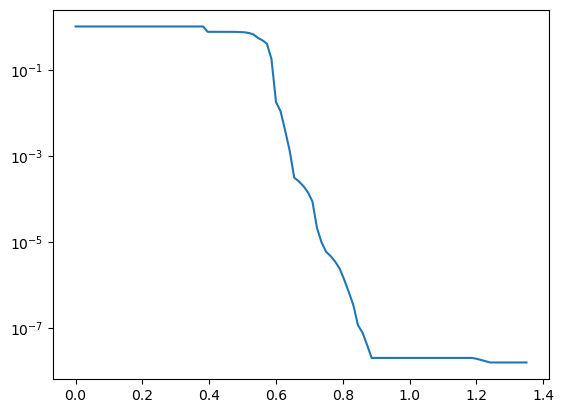

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6f63d4c40>

In [131]:
itp_mosek = linear_interpolation(Mosek_time, Mosek_obj)
a2 = Mosek_time[1]
b2 = 1.35

function f12_itp(x)
    if x>= a2 && x<= b2
        return itp_mosek(x) 
    end
    if x>=0 && x<a2
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time2= range(0,stop=b2,length=100)
PyPlot.semilogy(time2, [abs(f12_itp(i)-qt_long1[100000])/abs(f12_itp(0)-qt_long1[100000]) for i in time2])

In [169]:
# y3 = Variable(n)
# Prob = minimize(0.5*quadform(y3,Q; assume_psd=true)+dot(c,y3)-1, norm(A*y3 - b, 4) <= 1)
# @time Convex.solve!(Prob, MOI.OptimizerWithAttributes(COSMO.Optimizer, "time_limit"=>30.0))
# # @time Convex.solve!(Prob, SCS.Optimizer)
# # z = evaluate(y3)


model = Model(COSMO.Optimizer)

JuMP.@variable(model, y[1:n])
JuMP.@variable(model, r[1:m])
JuMP.@constraint(model, [i=1:m], [r[i], 1, (A[i,:]'*y-b[i])] in MOI.PowerCone(1 / 4))
JuMP.@constraint(model, sum(r) == 1)
JuMP.@objective(model, Min, 0.5*y'*Q*y + dot(c,y)-1)
@time optimize!(model)

------------------------------------------------------------------
          COSMO v0.8.7 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{2400},
          constraints: A ∈ R^{2401x2400} (1281600 nnz),
          matrix size to factor: 4801x4801,
          Floating-point precision: Float64
Sets:     PowerCone of dim: 3
          PowerCone of dim: 3
          PowerCone of dim: 3
          PowerCone of dim: 3
          PowerCone of dim: 3
          ... and 796 more
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Me

In [132]:
str3 =
"
1	-1.7545e+02	1.8929e+02	2.3859e+00	1.0000e-01
25	 9.6757e+01	3.3650e+01	6.6325e-01	1.0000e-01
50	 1.9456e+02	3.1971e+01	8.3997e-01	1.0000e-01
75	 4.2972e+02	2.3540e+01	1.0707e+00	1.0000e-01
100	 9.8504e+02	1.3495e+01	1.0849e+00	9.0241e-03
125	 2.5181e+03	8.5916e+01	9.0351e-01	8.7076e-04
150	 2.7238e+03	2.1406e+01	4.9917e-03	8.7076e-04
175	 2.6511e+03	1.9382e+01	8.4604e-03	8.7076e-04
200	 2.6282e+03	1.7381e+01	2.7728e-03	8.7076e-04
225	 2.2922e+03	7.2310e+00	3.0677e-03	8.7076e-04
250	 2.2136e+03	6.9116e+00	3.3686e-03	8.7076e-04
275	 1.8787e+03	1.4950e+01	3.5441e-03	8.7076e-04
300	 1.9074e+03	1.2476e+01	1.9271e-03	8.7076e-04
325	 2.0175e+03	7.9001e+00	2.8428e-03	8.7076e-04
350	 2.1039e+03	6.4846e+00	4.5368e-03	8.7076e-04
375	 2.2197e+03	6.8677e+00	3.7088e-03	8.7076e-04
400	 2.2948e+03	7.0755e+00	5.0263e-04	8.7076e-04
425	 2.0683e+03	7.1822e+00	8.1479e-04	8.7076e-04
450	 2.0318e+03	9.4851e+00	4.2070e-03	8.7076e-04
475	 1.9932e+03	1.0969e+01	1.6229e-03	8.7076e-04
500	 1.9726e+03	1.2032e+01	1.2803e-03	8.7076e-04
525	 2.0297e+03	9.6359e+00	1.6443e-03	8.7076e-04
550	 2.1451e+03	6.3837e+00	1.4791e-03	8.7076e-04
575	 2.2168e+03	6.6008e+00	3.4950e-03	8.7076e-04
600	 2.2325e+03	6.6156e+00	2.3559e-03	8.7076e-04
625	 2.2214e+03	6.5474e+00	1.0978e-03	8.7076e-04
650	 2.1717e+03	6.3394e+00	1.8162e-03	8.7076e-04
675	 2.0979e+03	8.2302e+00	3.1528e-03	8.7076e-04
700	 2.0552e+03	9.9465e+00	7.8615e-03	8.7076e-04
725	 2.0206e+03	1.1436e+01	1.3155e-03	8.7076e-04
750	 2.0292e+03	1.1051e+01	1.6904e-03	8.7076e-04
775	 2.0465e+03	1.0378e+01	1.1278e-03	8.7076e-04
800	 2.0657e+03	9.6452e+00	1.4141e-03	8.7076e-04
825	 2.1364e+03	6.9655e+00	1.6972e-03	8.7076e-04
850	 2.2062e+03	6.3674e+00	1.5920e-03	8.7076e-04
875	 2.2660e+03	6.5333e+00	7.4715e-04	8.7076e-04
900	 2.2858e+03	6.5636e+00	2.5431e-04	8.7076e-04
925	 2.2702e+03	6.4850e+00	9.6082e-04	8.7076e-04
950	 2.2545e+03	6.4175e+00	1.3004e-03	8.7076e-04
975	 2.2357e+03	6.3423e+00	1.5037e-03	8.7076e-04
1000	 2.2076e+03	6.2341e+00	1.6610e-03	8.7076e-04
1025	 2.1881e+03	6.1595e+00	1.7492e-03	8.7076e-04
1050	 2.1547e+03	7.3584e+00	1.7625e-03	8.7076e-04
1075	 2.1189e+03	8.8182e+00	1.5845e-03	8.7076e-04
1100	 2.0842e+03	1.0220e+01	1.1941e-03	8.7076e-04
1125	 2.0647e+03	1.1010e+01	7.0784e-04	8.7076e-04
1150	 2.0555e+03	1.1369e+01	9.6104e-05	8.7076e-04
1175	 2.0601e+03	1.1201e+01	3.2467e-04	8.7076e-04
1200	 2.0639e+03	1.1063e+01	5.0803e-04	8.7076e-04
1225	 2.0795e+03	1.0463e+01	8.7497e-04	8.7076e-04
1250	 2.0781e+03	1.0520e+01	7.5152e-04	8.7076e-04
1275	 2.1354e+03	8.3878e+00	1.2172e-03	8.7076e-04
1300	 2.1502e+03	7.8276e+00	1.3237e-03	8.7076e-04
1325	 2.1763e+03	6.8563e+00	1.4055e-03	8.7076e-04
1350	 2.2154e+03	6.1662e+00	1.3562e-03	8.7076e-04
1375	 2.2681e+03	6.3141e+00	9.9796e-04	8.7076e-04
1400	 2.2941e+03	6.3723e+00	3.5801e-04	8.7076e-04
1425	 2.2972e+03	6.3605e+00	2.1600e-04	8.7076e-04
1450	 2.2894e+03	6.3206e+00	5.7296e-04	8.7076e-04
1475	 2.2776e+03	6.2672e+00	8.8462e-04	8.7076e-04
1500	 2.2634e+03	6.2083e+00	1.1082e-03	8.7076e-04
1525	 2.2526e+03	6.1663e+00	1.2178e-03	8.7076e-04
"
# "
# 1	-5.1558e+02	3.5118e+02	2.7987e+00	1.0000e-01
# 25	 1.2032e+02	7.1752e+01	1.6367e+00	1.0000e-01
# 50	 3.3641e+02	5.9305e+01	1.3603e+00	1.8630e-02
# 75	 1.5090e+03	1.7387e+01	5.8378e-01	1.8630e-02
# 100	 3.2391e+03	7.2540e+01	4.6449e-01	2.2033e-03
# 125	 8.7372e+03	3.4106e+02	2.7867e-01	2.2033e-03
# 150	 1.1524e+04	3.5348e+02	2.0438e-01	3.3369e-04
# 175	 8.0850e+03	1.8570e+02	1.3618e-02	3.3369e-04
# 200	 6.2872e+03	1.0227e+02	1.3617e-02	3.3369e-04
# 225	 5.1151e+03	5.0923e+01	1.8082e-02	3.3369e-04
# 250	 2.8000e+03	5.0440e+01	7.6839e-03	3.3369e-04
# 275	 2.1270e+03	7.9831e+01	4.7224e-03	3.3369e-04
# 300	 1.9512e+03	8.7901e+01	1.3715e-03	3.3369e-04
# 325	 1.9359e+03	8.8472e+01	5.1266e-03	1.8398e-03
# 350	 1.9642e+03	8.6715e+01	9.3306e-03	1.8398e-03
# 375	 2.0110e+03	8.4293e+01	1.4571e-02	1.8398e-03
# 400	 2.1860e+03	7.6021e+01	2.0581e-02	1.8398e-03
# 425	 2.2833e+03	7.1420e+01	2.4131e-02	1.8398e-03
# 450	 2.3803e+03	6.7166e+01	2.1382e-02	1.8398e-03
# 475	 3.1009e+03	3.8733e+01	5.1096e-03	1.8398e-03
# 500	 3.1897e+03	3.5933e+01	4.4572e-03	1.8398e-03
# 525	 3.1984e+03	3.5573e+01	3.4389e-03	1.8398e-03
# 550	 3.2103e+03	3.5290e+01	1.0470e-02	1.8398e-03
# 575	 3.2359e+03	3.4016e+01	4.7870e-03	1.8398e-03
# 600	 3.2686e+03	3.2377e+01	6.3739e-03	1.8398e-03
# 625	 3.3109e+03	3.0148e+01	7.6880e-03	1.8398e-03
# 650	 3.3555e+03	2.7997e+01	8.6129e-03	1.8398e-03
# 675	 3.4120e+03	2.4686e+01	9.2485e-03	1.8398e-03
# 700	 3.4786e+03	2.1740e+01	9.5393e-03	1.8398e-03
# 725	 3.5436e+03	1.9465e+01	9.3850e-03	1.8398e-03
# 750	 3.6055e+03	1.5384e+01	8.8183e-03	1.8398e-03
# 775	 3.6635e+03	1.3368e+01	9.9133e-03	1.8398e-03
# 800	 3.7238e+03	1.3200e+01	6.0840e-03	1.8398e-03
# 825	 3.7756e+03	1.3198e+01	8.8610e-03	1.8398e-03
# 850	 3.7955e+03	1.3151e+01	6.3964e-03	1.8398e-03
# 875	 3.8025e+03	1.3029e+01	1.8047e-03	1.8398e-03
# 900	 3.7943e+03	1.2866e+01	3.1094e-03	1.8398e-03
# 925	 3.7674e+03	1.2592e+01	1.0095e-02	1.8398e-03
# 950	 3.7186e+03	1.2260e+01	6.4523e-03	1.8398e-03
# 975	 3.6618e+03	1.2280e+01	7.7870e-03	1.8398e-03
# 1000	 3.5786e+03	1.3969e+01	8.8069e-03	1.8398e-03
# 1025	 3.4861e+03	1.8119e+01	9.2170e-03	1.8398e-03
# 1050	 3.4337e+03	1.9202e+01	8.9931e-03	1.8398e-03
# 1075	 3.3493e+03	2.0557e+01	8.2846e-03	1.8398e-03
# 1100	 3.2489e+03	2.5074e+01	6.7743e-03	1.8398e-03
# 1125	 3.1737e+03	2.5266e+01	4.6936e-03	1.8398e-03
# 1150	 3.1363e+03	2.6229e+01	2.0974e-03	1.8398e-03
# 1175	 3.1271e+03	2.7773e+01	7.0373e-04	1.8398e-03
# 1200	 3.1334e+03	2.7135e+01	1.3108e-03	1.8398e-03
# 1225	 3.1435e+03	2.6396e+01	1.9639e-03	1.8398e-03
# 1250	 3.1457e+03	2.6582e+01	2.1101e-03	1.8398e-03
# 1275	 3.1536e+03	2.7296e+01	2.0620e-03	1.8398e-03
# 1300	 3.3491e+03	1.9084e+01	2.2958e-03	1.8398e-03
# 1325	 3.3579e+03	2.1029e+01	2.9057e-03	1.8398e-03
# 1350	 3.3941e+03	1.9830e+01	3.5482e-03	1.8398e-03
# 1375	 3.4646e+03	1.8118e+01	4.4657e-03	1.8398e-03
# 1400	 3.5615e+03	1.6554e+01	5.0028e-03	1.8398e-03
# 1425	 3.6236e+03	1.4231e+01	4.7055e-03	1.8398e-03
# 1450	 3.6640e+03	1.3036e+01	4.2627e-03	1.8398e-03
# 1475	 3.7046e+03	1.4012e+01	3.5794e-03	1.8398e-03
# 1500	 3.7477e+03	1.1359e+01	2.5786e-03	1.8398e-03
# 1525	 3.7754e+03	1.1745e+01	1.7136e-03	1.8398e-03
# 1550	 3.7998e+03	1.2827e+01	2.2295e-03	1.8398e-03
# 1575	 3.8000e+03	1.1748e+01	9.0607e-04	1.8398e-03
# 1600	 3.7907e+03	1.3953e+01	1.1016e-03	1.8398e-03
# 1625	 3.7571e+03	1.6200e+01	2.4556e-03	1.8398e-03
# 1650	 3.7221e+03	1.6373e+01	2.0492e-03	1.8398e-03
# 1675	 3.7063e+03	1.7658e+01	1.5872e-03	1.8398e-03

# "
# "
# 1	-5.7161e+02	6.5538e+02	2.9893e+00	1.0000e-01
# 25	 3.1086e+02	1.6516e+02	3.6274e+00	1.0000e-01
# 50	 5.4373e+02	1.3152e+02	2.0810e+00	1.0000e-01
# 75	 8.7295e+02	1.3852e+02	2.5317e+00	1.0000e-01
# 100	 1.6336e+03	1.0735e+02	2.8840e+00	1.1201e-02
# 125	 6.0216e+03	2.4246e+02	9.2828e-01	8.0328e-04
# "

# "
# 1	 2.9540e+03	1.9010e+01	6.5626e+01	1.0000e-01
# 25	 1.5973e+04	5.4792e-01	4.8476e-01	1.0000e-01
# 50	 1.6273e+04	2.4111e-01	7.7111e-02	1.0000e-01
# 75	 1.6720e+04	1.9305e-01	1.9354e-01	1.0000e-01
# 100	 1.6741e+04	5.6459e-02	1.9569e-02	5.6454e-01
# 125	 1.6973e+04	6.1352e-02	4.0026e-01	5.6454e-01
# 150	 1.7048e+04	3.1137e-02	2.6461e-01	5.6454e-01
# 175	 1.7068e+04	8.9186e-03	3.6839e-03	5.6454e-01
# 200	 1.7113e+04	5.1243e-03	2.1761e-03	5.6454e-01
# 225	 1.7134e+04	3.5006e-03	1.8485e-02	5.6454e-01
# 250	 1.7158e+04	1.8959e-03	1.8956e-04	5.6454e-01
# 275	 1.7182e+04	5.0445e-04	4.7818e-03	5.6454e-01
# "
# "
# 1	 1.7021e+04	2.8645e+01	1.8102e+02	1.0000e-01
# 25	 6.5459e+04	1.0789e+00	8.2703e-01	1.0000e-01
# 50	 6.5691e+04	2.9249e-01	3.4875e-01	1.0000e-01
# 75	 6.7163e+04	8.9213e-02	9.1726e-02	1.0000e-01
# 100	 6.7474e+04	6.4156e-02	1.9026e-02	1.0000e-01
# 125	 6.7743e+04	4.6543e-02	4.1911e-02	1.0000e-01
# 150	 6.7933e+04	5.7568e-02	7.3524e-02	1.0000e-01
# 175	 6.8121e+04	2.9197e-02	5.1320e-02	1.0000e-01
# 200	 6.8256e+04	2.3137e-02	1.4454e-02	1.0000e-01
# 225	 6.8446e+04	1.1257e-01	1.1030e+00	6.2950e-01
# 250	 6.8780e+04	2.1357e-02	3.5201e-01	6.2950e-01
# 275	 6.9279e+04	6.1608e-02	1.2023e+00	6.2950e-01
# 300	 6.9418e+04	2.2504e-08	7.8657e-08	6.2950e-01
# "

# "
# 1	 1.0347e+05	5.8253e+01	4.5252e+02	1.0000e-01
# 25	 2.7947e+05	1.0000e+00	1.3034e+00	1.0000e-01
# 50	 2.8130e+05	2.4880e-01	9.5609e-01	1.0000e-01
# 75	 2.8441e+05	8.1222e-02	1.9430e-01	1.0000e-01
# 100	 2.8560e+05	1.0578e-01	3.6635e-01	1.0000e-01
# 125	 2.8646e+05	1.2679e-01	3.1160e-01	1.0000e-01
# 150	 2.8704e+05	1.3790e-01	6.2317e-01	1.0000e-01
# 175	 2.8705e+05	2.4528e-02	2.5956e-03	1.0000e-01
# 200	 2.8730e+05	2.1799e-02	4.6527e-03	1.0000e-01
# 225	 2.8751e+05	5.1436e-02	2.1206e-02	1.0000e-01
# 250	 2.8795e+05	1.5138e-02	2.5552e-01	3.8350e+00
# 275	 2.8841e+05	1.1705e-02	4.4740e-02	3.8350e+00
# 300	 2.8844e+05	1.1433e-02	4.2280e-02	3.8350e+00
# 325	 2.8848e+05	1.1201e-02	4.0614e-02	3.8350e+00
# 350	 2.8851e+05	1.0956e-02	3.9065e-02	3.8350e+00
# 375	 2.8854e+05	1.0742e-02	3.7622e-02	3.8350e+00
# 400	 2.8857e+05	1.0528e-02	3.6273e-02	3.8350e+00
# 425	 2.8860e+05	1.0323e-02	3.5011e-02	3.8350e+00
# 450	 2.8863e+05	1.0133e-02	3.3827e-02	3.8350e+00
# 475	 2.8866e+05	9.9509e-03	3.2715e-02	3.8350e+00
# 500	 2.8869e+05	9.7721e-03	3.1668e-02	3.8350e+00
# 525	 2.8871e+05	9.6147e-03	3.0681e-02	3.8350e+00
# 550	 2.8874e+05	9.4447e-03	2.9749e-02	3.8350e+00
# 575	 2.8876e+05	9.2872e-03	2.8868e-02	3.8350e+00
# 600	 2.8878e+05	9.1479e-03	2.8033e-02	3.8350e+00
# 625	 2.8881e+05	8.9983e-03	2.7241e-02	3.8350e+00
# 650	 2.8883e+05	8.8504e-03	2.6490e-02	3.8350e+00
# 675	 2.8885e+05	8.7272e-03	2.5775e-02	3.8350e+00
# 700	 2.8887e+05	8.6032e-03	2.5095e-02	3.8350e+00
# 725	 2.8889e+05	8.4688e-03	2.4447e-02	3.8350e+00
# 750	 2.8891e+05	8.3556e-03	2.3829e-02	3.8350e+00
# 775	 2.8893e+05	8.2353e-03	2.3239e-02	3.8350e+00
# 800	 2.8895e+05	8.1189e-03	2.2675e-02	3.8350e+00
# 825	 2.8897e+05	8.0146e-03	2.2136e-02	3.8350e+00
# 850	 2.8899e+05	7.9164e-03	2.1619e-02	3.8350e+00
# 875	 2.8901e+05	7.8128e-03	2.1125e-02	3.8350e+00
# 900	 2.8902e+05	7.6984e-03	2.0650e-02	3.8350e+00
# 925	 2.8904e+05	7.6134e-03	2.0194e-02	3.8350e+00
# 950	 2.8906e+05	7.5141e-03	1.9757e-02	3.8350e+00
# 975	 2.8907e+05	7.4260e-03	1.9336e-02	3.8350e+00
# 1000	 2.8909e+05	7.3392e-03	1.8932e-02	3.8350e+00
# 1025	 2.8911e+05	7.2592e-03	1.8543e-02	3.8350e+00
# 1050	 2.8912e+05	7.1775e-03	1.8167e-02	3.8350e+00
# 1075	 2.8914e+05	7.0938e-03	1.7806e-02	3.8350e+00
# 1100	 2.8915e+05	7.0108e-03	1.7457e-02	3.8350e+00
# 1125	 2.8917e+05	6.9309e-03	1.7121e-02	3.8350e+00
# 1150	 2.8918e+05	6.8606e-03	1.6796e-02	3.8350e+00
# 1175	 2.8919e+05	6.7853e-03	1.6483e-02	3.8350e+00
# 1200	 2.8921e+05	6.7089e-03	1.6179e-02	3.8350e+00
# 1225	 2.8922e+05	6.6440e-03	1.5886e-02	3.8350e+00
# 1250	 2.8923e+05	6.5827e-03	1.5602e-02	3.8350e+00
# 1275	 2.8925e+05	6.5152e-03	1.5328e-02	3.8350e+00
# 1300	 2.8926e+05	6.4517e-03	1.5061e-02	3.8350e+00
# 1325	 2.8927e+05	6.3929e-03	1.4804e-02	3.8350e+00
# 1350	 2.8928e+05	6.3323e-03	1.4554e-02	3.8350e+00
# 1375	 2.8930e+05	6.2676e-03	1.4311e-02	3.8350e+00
# 1400	 2.8931e+05	6.2122e-03	1.4076e-02	3.8350e+00
# 1425	 2.8932e+05	6.1470e-03	1.3848e-02	3.8350e+00
# 1450	 2.8933e+05	6.0921e-03	1.3626e-02	3.8350e+00
# 1475	 2.8934e+05	6.0263e-03	1.3411e-02	3.8350e+00
# 1500	 2.8935e+05	5.9779e-03	1.3202e-02	3.8350e+00
# 1525	 2.8936e+05	5.9227e-03	1.2999e-02	3.8350e+00
# 1550	 2.8937e+05	5.8610e-03	1.2801e-02	3.8350e+00
# "
COSMO_obj, notUsed = extract_vectors(str3, 2, 3)

([-175.45, 96.757, 194.56, 429.72, 985.04, 2518.1, 2723.8, 2651.1, 2628.2, 2292.2  …  2150.2, 2176.3, 2215.4, 2268.1, 2294.1, 2297.2, 2289.4, 2277.6, 2263.4, 2252.6], [189.29, 33.65, 31.971, 23.54, 13.495, 85.916, 21.406, 19.382, 17.381, 7.231  …  7.8276, 6.8563, 6.1662, 6.3141, 6.3723, 6.3605, 6.3206, 6.2672, 6.2083, 6.1663])

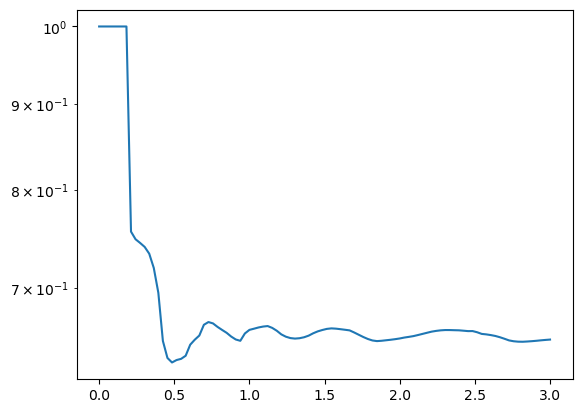

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6f6736f40>

In [133]:
COSMO_time = range(0.202,stop=3.0,length=62)
# COSMO_time = range(1.905,stop=15,length=68)
# COSMO_time = range(5,stop=30,length=6)

# COSMO_time = range(0.063,stop=0.484,length=12)
# COSMO_time = range(0.481,stop=1.997,length=13)
# COSMO_time = range(3.8,stop=30,length=63)

COSMO_obj = COSMO_obj[1:62]
# COSMO_obj = COSMO_obj[1:68]
# COSMO_obj = COSMO_obj[1:6]

# COSMO_obj = COSMO_obj[1:12]
# COSMO_obj = COSMO_obj[1:13]
# COSMO_obj = COSMO_obj[1:63]

itp_COSMO = linear_interpolation(COSMO_time, COSMO_obj)
# f3_itp = x-> itp_COSMO(x) -r1_long[100000]
a3 = COSMO_time[1]
b3 = 3
function f13_itp(x)
    if x>= a3 && x<= b3
        return itp_COSMO(x)
    end
    if x>=0 && x<a3
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time3= range(0,stop=b3,length=100)
PyPlot.semilogy(time3, [abs(f13_itp(i)-qt_long1[100000])/abs(f13_itp(0)-qt_long1[100000]) for i in time3])


In [424]:
f13_itp(0.202)

17363.227352180777

In [44]:
# y4 = Variable(n)
# Prob = minimize(0.5*quadform(y4,Q; assume_psd=true)+dot(c,y4)-1, norm(A*y4 - b, 4) <= 1)
# @time Convex.solve!(Prob, SCS.Optimizer)
# # z = evaluate(y3)

model = Model(SCS.Optimizer)

JuMP.@variable(model, y[1:n])
JuMP.@variable(model, r[1:m])
JuMP.@constraint(model, [i=1:m], [r[i], 1, (A[i,:]'*y-b[i])] in MOI.PowerCone(1 / 4))
JuMP.@constraint(model, sum(r) == 1)
JuMP.@objective(model, Min, 0.5*y'*Q*y + dot(c,y)-1)
@time optimize!(model)

 21.653148 seconds (17.99 M allocations: 1013.993 MiB, 1.15% gc time, 49.95% compilation time)
------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 601, constraints m: 1003
cones: 	  z: primal zero / dual free vars: 1
	  q: soc vars: 402, qsize: 1
	  p: primal + dual power vars: 600
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 161402, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 6.44e+02  2.71e+00  

In [134]:
str4 =
"
     0| 2.64e+02  2.98e+00  5.85e+02 -1.17e+02  1.00e-01  2.94e-01 
   250| 9.13e+00  1.71e-01  1.22e+01  3.93e+03  2.25e-03  9.18e-01 
   500| 3.16e+01  9.03e-05  8.05e-02  5.99e+03  2.10e-04  1.41e+00 
   750| 3.20e+01  4.67e-05  3.50e-02  6.01e+03  2.10e-04  1.78e+00 
  1000| 3.16e+01  2.11e-03  2.89e-01  6.12e+03  2.43e-03  2.40e+00 
  1250| 3.08e+01  1.69e-03  2.69e-01  6.32e+03  2.43e-03  2.77e+00 
  1500| 2.98e+01  1.65e-03  4.58e-01  6.50e+03  2.43e-03  3.14e+00 
  1750| 7.79e+02  1.49e+00  4.49e-01  7.57e+03  2.43e-03  3.50e+00 
  2000| 2.76e+01  1.98e-03  5.55e-01  6.77e+03  2.43e-03  3.87e+00 
  2250| 2.64e+01  2.04e-03  4.95e-01  6.89e+03  2.43e-03  4.24e+00 
  2500| 2.53e+01  2.04e-03  4.46e-01  6.99e+03  2.43e-03  4.60e+00 
  2750| 2.42e+01  2.01e-03  4.16e-01  7.09e+03  2.43e-03  4.97e+00 
  3000| 2.32e+01  1.98e-03  3.92e-01  7.17e+03  2.43e-03  5.34e+00 
  3250| 2.21e+01  1.93e-03  3.71e-01  7.24e+03  2.43e-03  5.70e+00 
  3500| 1.36e+01  1.16e-03  3.23e+00  7.69e+03  2.43e-03  6.07e+00 
  3750| 1.30e+01  1.57e-03  1.67e+00  7.70e+03  2.43e-03  6.43e+00 
  4000| 1.25e+01  1.70e-03  8.28e-01  7.72e+03  2.43e-03  6.80e+00 
  4250| 1.20e+01  1.51e-03  4.45e-01  7.75e+03  2.43e-03  7.16e+00 
  4500| 1.15e+01  1.34e-03  2.75e-01  7.77e+03  2.43e-03  7.52e+00 
  4750| 1.78e+00  2.20e-03  7.41e-01  8.06e+03  2.43e-03  7.89e+00 
  4800| 1.26e+00  1.08e-05  5.36e-01  8.08e+03  2.43e-03  7.97e+00 
"
# "
#      0| 4.58e+02  3.50e+00  1.23e+03 -2.74e+02  1.00e-01  1.70e+00 
#    250| 9.97e+01  1.51e-01  3.54e+02  1.28e+04  2.35e-03  4.91e+00 
#    500| 2.04e+02  8.74e-03  7.54e+01  1.07e+04  1.01e-04  8.09e+00 
#    750| 6.23e+01  8.65e-06  5.48e-02  1.05e+04  1.01e-04  9.39e+00 
#   1000| 6.36e+01  4.98e-04  9.05e-01  1.07e+04  3.44e-04  1.17e+01 
#   1250| 7.00e+01  4.92e-03  4.18e+00  1.15e+04  1.10e-03  1.40e+01 
#   1500| 7.50e+01  3.25e-03  4.03e+00  1.23e+04  1.10e-03  1.52e+01 
# "



# "
#      0| 8.00e+02  3.74e+00  2.18e+03  8.78e+01  1.00e-01  2.19e+01 
#    250| 7.15e+19  1.20e+17  8.71e+20  4.22e+21  2.66e-03  6.71e+01 
#    500| 5.08e+02  4.20e-02  2.88e+02  1.89e+04  7.87e-05  1.14e+02
# "
# "
#      0| 6.44e+02  2.71e+00  1.41e+03 -5.64e+02  1.00e-01  1.40e-01 
#    250| 1.37e+01  1.50e-03  5.32e+00  7.96e+03  5.11e-03  4.53e-01 
#    500| 1.31e+01  1.33e-03  4.41e+00  8.70e+03  5.11e-03  6.71e-01 
#    750| 2.45e+03  4.08e+00  1.37e+02  2.01e+04  5.11e-03  8.88e-01 
#   1000| 1.18e+01  1.24e-03  3.35e+00  9.97e+03  5.11e-03  1.11e+00 
#   1250| 1.12e+01  1.13e-03  2.96e+00  1.05e+04  5.11e-03  1.36e+00 
#   1500| 1.07e+01  1.09e-03  2.64e+00  1.10e+04  5.11e-03  1.76e+00 
#   1750| 1.02e+01  1.03e-03  2.37e+00  1.15e+04  5.11e-03  2.02e+00 
#   2000| 9.72e+00  9.82e-04  2.13e+00  1.19e+04  5.11e-03  2.24e+00 
#   2250| 9.26e+00  9.67e-04  1.93e+00  1.23e+04  5.11e-03  2.46e+00 
#   2500| 8.82e+00  8.86e-04  1.75e+00  1.26e+04  5.11e-03  2.68e+00 
#   2750| 8.40e+00  8.45e-04  1.61e+00  1.29e+04  5.11e-03  2.90e+00 
#   3000| 8.02e+00  7.84e-04  1.47e+00  1.32e+04  5.11e-03  3.12e+00 
# "

# "
#      0| 1.02e+03  3.69e+00  2.48e+03 -1.03e+03  1.00e-01  7.29e-01 
#    250| 3.09e+01  1.21e-03  1.46e+01  2.02e+04  3.67e-03  2.24e+00 
#    500| 3.00e+01  1.85e-03  1.19e+01  2.23e+04  3.67e-03  3.02e+00 
#   1000| 2.82e+01  1.70e-03  9.43e+00  2.61e+04  3.67e-03  4.56e+00 
#   1250| 2.74e+01  1.66e-03  8.49e+00  2.79e+04  3.67e-03  5.33e+00 
#   1500| 2.67e+01  1.65e-03  7.71e+00  2.96e+04  3.67e-03  6.08e+00 
#   1750| 2.60e+01  1.61e-03  7.05e+00  3.11e+04  3.67e-03  6.85e+00 
#   2000| 2.53e+01  1.55e-03  6.48e+00  3.27e+04  3.67e-03  7.66e+00 
#   2250| 2.46e+01  1.57e-03  5.98e+00  3.41e+04  3.67e-03  8.50e+00 
#   2500| 2.40e+01  1.49e-03  5.53e+00  3.55e+04  3.67e-03  9.35e+00 
#   2750| 2.34e+01  1.48e-03  5.13e+00  3.68e+04  3.67e-03  1.02e+01 
#   3000| 2.28e+01  1.39e-03  4.78e+00  3.81e+04  3.67e-03  1.10e+01 
#   3250| 2.22e+01  1.36e-03  4.47e+00  3.92e+04  3.67e-03  1.19e+01 
#   3500| 3.14e+03  3.60e+00  2.03e+02  6.89e+04  3.67e-03  1.27e+01 
#   3750| 2.11e+01  1.36e-03  3.93e+00  4.14e+04  3.67e-03  1.35e+01 
#   4000| 2.06e+01  1.28e-03  3.67e+00  4.25e+04  3.67e-03  1.43e+01 
#   4250| 2.01e+01  1.25e-03  3.47e+00  4.35e+04  3.67e-03  1.54e+01 
# "



# "
#      0| 1.59e+03  3.76e+00  3.76e+03 -1.12e+03  1.00e-01  5.66e+00 
#    250| 5.25e+01  4.67e-04  1.04e+01  5.04e+04  1.07e-03  1.59e+01 
#    500| 5.21e+01  4.94e-04  9.77e+00  5.27e+04  1.07e-03  1.88e+01 
#    750| 4.87e+04  5.09e+00  3.78e+02  1.84e+05  1.07e-03  2.17e+01 
#   1000| 5.14e+01  4.15e-04  8.86e+00  5.71e+04  1.07e-03  2.46e+01 
#   1250| 5.11e+01  3.85e-04  8.47e+00  5.93e+04  1.07e-03  2.76e+01 
#   1500| 5.07e+01  4.12e-04  8.11e+00  6.15e+04  1.07e-03  3.05e+01 
# "
SCS_obj, SCS_time = extract_vectors(str4, 5, 7)


([-117.0, 3930.0, 5990.0, 6010.0, 6120.0, 6320.0, 6500.0, 7570.0, 6770.0, 6890.0  …  7090.0, 7170.0, 7240.0, 7690.0, 7700.0, 7720.0, 7750.0, 7770.0, 8060.0, 8080.0], [0.294, 0.918, 1.41, 1.78, 2.4, 2.77, 3.14, 3.5, 3.87, 4.24  …  4.97, 5.34, 5.7, 6.07, 6.43, 6.8, 7.16, 7.52, 7.89, 7.97])

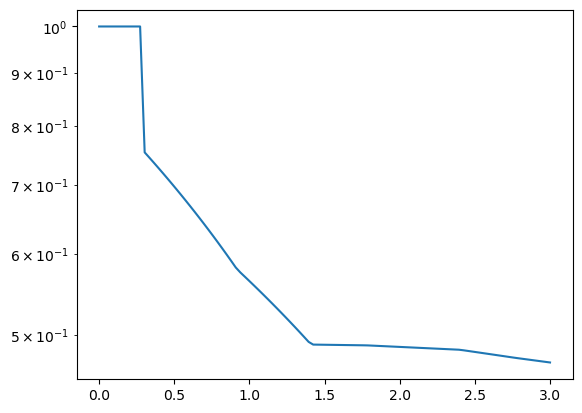

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe6f6b4eaf0>

In [135]:
SCS_obj = SCS_obj[1:7]
# SCS_obj = [-274.0, 12800.0, 10700.0, 10500.0, 10700.0, 11500.0, 12300.0]
# SCS_obj = [87.8, 18900.0]

# SCS_obj = [-564.0, 7960.0, 8700.0, 9970.0, 10500.0, 11000.0, 11500.0, 11900.0, 12300.0, 12600.0, 12900.0, 13200.0]
# SCS_obj = SCS_obj[1:17]
# SCS_obj = SCS_obj[1:7]

SCS_obj = cleanData2(SCS_obj)


SCS_time = SCS_time[1:7]
# SCS_time = [1.7, 4.91, 8.09, 9.39, 11.7, 14.0, 15.2]
# SCS_time = [21.9, 114.0]


# SCS_time = [0.14, 0.453, 0.671, 1.11, 1.36, 1.76, 2.02, 2.24, 2.46, 2.68, 2.9, 3.12]
# SCS_time = SCS_time[1:17]
# SCS_time = SCS_time[1:7]

itp_SCS = linear_interpolation(SCS_time, SCS_obj)
# f4_itp = x-> itp_SCS(x) -r1_long[100000]
a4 = SCS_time[1]
b4 = 3
function f14_itp(x)
    if x>= a4 && x<= b4
        return itp_SCS(x)
    end
    if x>=0 && x<a4
        return 0.5*e'*Q*e.+dot(c,e)-1
    end
end
time4= range(0,stop=b4,length=100)
PyPlot.semilogy(time4, [abs(f14_itp(i)-qt_long1[100000])/abs(f14_itp(0)-qt_long1[100000]) for i in time4])



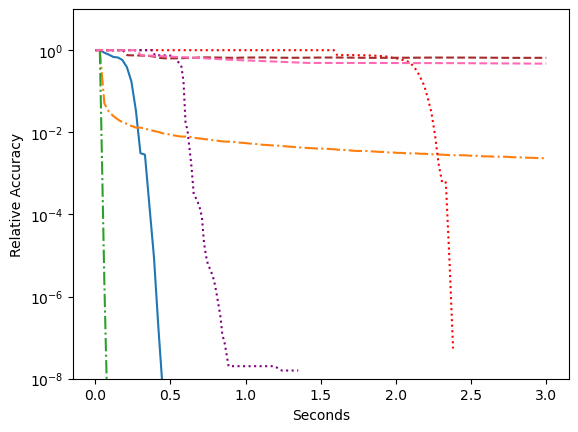

In [137]:
experiment_time = 3
sample = 100
f0 = obj_grad(x0)[1] + 0.5*e'*Q*e.+dot(c,e)


qt1, step1 = radial_accelerate(rad_obj_grad1, rad_obj_grad4 , x0, 7.6, 0.0012, experiment_time, sample)
qt1 =qt1 .+ 0.5*e'*Q*e.+dot(c,e)
qt2, step2 = sw_subgrad(sw_obj_grad2,x0,0.016,0.019,experiment_time,sample)
qt2 = qt2 .+ 0.5*e'*Q*e.+dot(c,e)
qt3, step3 = agd(lagrange_obj_grad2,x0,180000,19,experiment_time,sample)
qt3 = qt3 .+ 0.5*e'*Q*e.+dot(c,e)

qt1 = cleanData(qt1)
qt2 = cleanData(qt2)
qt3 = cleanData(qt3)
PyPlot.semilogy((experiment_time/sample).*(1:sample), (qt1.-qt_long1[100000])/(f0-qt_long1[100000]), label = "Radial_GenGrad_Accel")
PyPlot.semilogy((experiment_time/sample).*(1:sample), (qt2.-qt_long1[100000])/(f0-qt_long1[100000]), label = "Switching_Subgrad", linestyle = "dashdot")
PyPlot.semilogy((experiment_time/sample).*(1:sample), (qt3.-qt_long1[100000])/(f0-qt_long1[100000]), label = "Ideal_Lagrange_Accel", linestyle = "dashdot")
PyPlot.semilogy(time1, [abs(f11_itp(i)-qt_long1[100000])/(f0-qt_long1[100000]) for i in time1], label = "Gurobi", linestyle = "dotted", color="red")
PyPlot.semilogy(time2, [abs(f12_itp(i)-qt_long1[100000])/(f0-qt_long1[100000]) for i in time2], label = "Mosek", linestyle = "dotted", color="purple")
PyPlot.semilogy(time3, [abs(f13_itp(i)-qt_long1[100000])/(f0-qt_long1[100000]) for i in time3], label = "COSMO", linestyle = "dashed", color="brown")
PyPlot.semilogy(time4, [abs(f14_itp(i)-qt_long1[100000])/(f0-qt_long1[100000]) for i in time4], label = "SCS", linestyle = "dashed", color ="hotpink")

# legend(bbox_to_anchor=(1.0,1.0))
# legend()
ylim(1e-8,1e1)
xlabel("Seconds")
ylabel("Relative Accuracy")
savefig("up_cquartic_solver_400")
# savefig("up_cquartic_solver_1600", bbox_inches="tight")

